In [75]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
from tqdm.notebook import tqdm
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [3]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))
    
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)    

In [4]:
def avail_actions(s):
    string_array = np.array(list(s))
    return np.where(string_array == '1')[0]

def not_avail_actions(s):
    string_array = np.array(list(s))
    return np.where(string_array != '1')[0]

def play(env, Q, print_board=False, random_X=False, random_0=False):
    env.reset()
    s, empty_spaces, turn = env.getState()
    done = False
    pX=1
    p0=-1
    player = pX
    while not done:
        if player == pX and random_X or player == p0 and random_0:
            action = random.choice(avail_actions(s))
        else:
            action = np.argmax(Q[s])
        a = env.action_from_int(action)
        (s, empty_spaces, turn), reward, done, _ = env.step(a)
        if print_board:
            plot_board(env, None)
            #env.printBoard()
        player = - player
                    
    if reward == 1:
        return (1, 0)
    elif reward == -1:
        return (0, 1)
    else:
        return (0, 0)

def evaluate(env, Q, n=1000, disable_tqdm=False, random_X=False, random_0=False):
    rewardsX = []
    rewards0 = []
    for _ in tqdm(range(n), disable=disable_tqdm):
        rewardX, reward0 = play(env, Q, print_board=False, random_X=random_X, random_0=random_0)
        rewardsX.append(rewardX)
        rewards0.append(reward0)
    rX = np.mean(rewardsX)
    r0 = np.mean(rewards0)
    draw = 1 - rX - r0
    return rX, r0, draw

class Agent:
    def __init__(self, alpha, gamma, s=None, a=None):
        self.state = s
        self.action = a
        self.alpha = alpha
        self.gamma = gamma
        
    def update_Q(self, Q, state, action, reward):
        Q[self.state][self.action] = Q[self.state][self.action] + \
                                     self.alpha * (reward + self.gamma * np.max(Q[state]) - Q[self.state][self.action])
        self.state = state
        self.action = action
        
def Q_learning_episode(env, Q, A, alpha=0.05, epsilon=0.1, gamma=1):
    env.reset()
    s, empty_spaces, turn = env.getState()    
    agents = (
        Agent(alpha=alpha, gamma=gamma), 
        Agent(alpha=alpha, gamma=gamma)
    )
    done = False
    agent_idx = 0
    
    while not done:
        Q[s][not_avail_actions(s)] = -9999
        a = np.argmax(Q[s]) if random.random() < (1 - epsilon) else random.choice(avail_actions(s))
        agent = agents[agent_idx]
        agent.update_Q(Q, s, a, 0)
        agent_idx = 1 - agent_idx 
        (s, empty_spaces, turn), r , done, _ = env.step(env.action_from_int(a))    

    if r == -10:
        agent.update_Q(Q, s, a, r)
    else:
        agents[0].update_Q(Q, s, a, r) 
        agents[1].update_Q(Q, s, a, -r) 
        
    return Q

def Q_learning(env, Q, A, episodes=100_000, alpha=0.05, evaluate_every=1000, epsilon=0.3, gamma=1, disable_tqdm=False):
    hist_X = []
    hist_0 = []
    iters = []

    for i in tqdm(range(episodes), disable=disable_tqdm):
        Q = Q_learning_episode(env=env, Q=Q, A=A, alpha=alpha, epsilon=epsilon, gamma=gamma)
        if i % evaluate_every == 0:
            res_X = evaluate(env, Q, n=100, disable_tqdm=True, random_X=False, random_0=True)[0]
            res_0 = evaluate(env, Q, n=100, disable_tqdm=True, random_X=True, random_0=False)[1]
            hist_X.append(res_X)
            hist_0.append(res_0)
            iters.append(i)
            
    return Q, (hist_X, hist_0), iters


In [5]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
game_hash, empty_spaces, _ = env.getState()
A = tuple(range(len(empty_spaces)))
Q = defaultdict(lambda: np.zeros(len(A)))

In [6]:
Q, (hist_X, hist_0), iters = Q_learning(env, Q, A, episodes=200000, alpha=0.9, epsilon=0.5)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [02:59<00:00, 1113.53it/s]


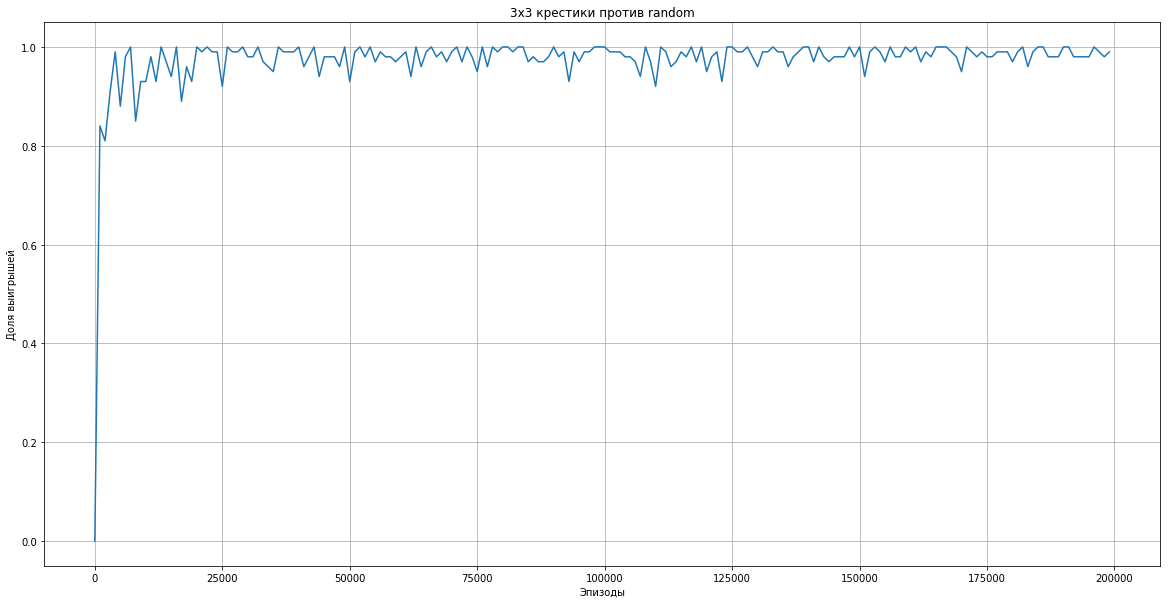

In [7]:
plt.figure(figsize=(20, 10))
plt.title('3x3 крестики против random')
plt.xlabel('Эпизоды')
plt.ylabel('Доля выигрышей')
plt.grid(True)
plt.plot(iters, hist_X);

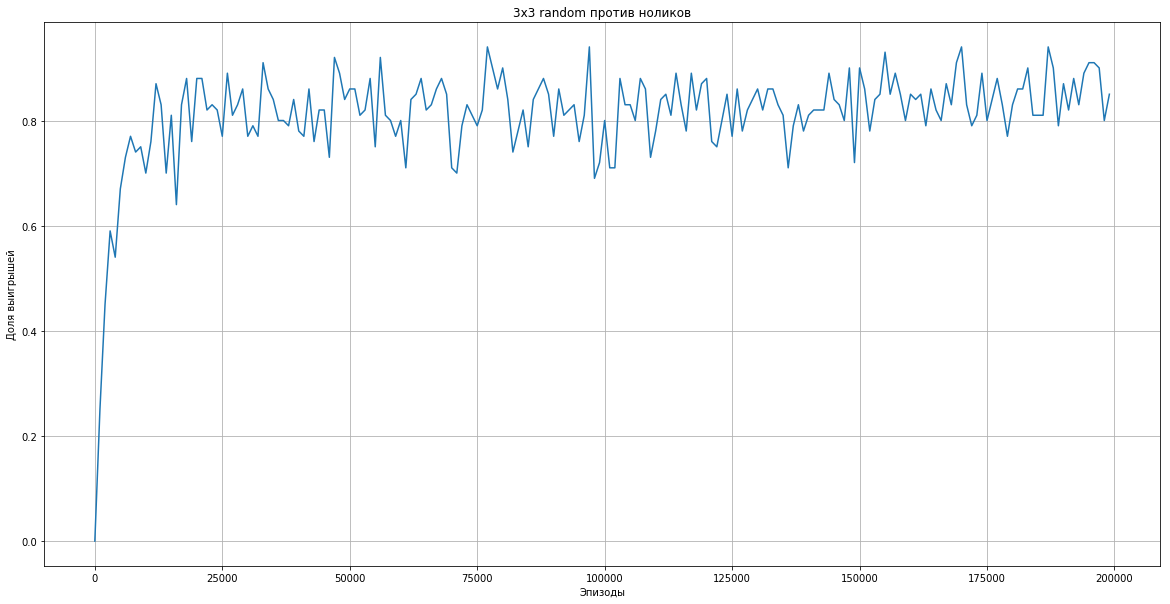

In [8]:
plt.figure(figsize=(20, 10))
plt.title('3x3 random против ноликов')
plt.xlabel('Эпизоды')
plt.ylabel('Доля выигрышей')
plt.grid(True)
plt.plot(iters, hist_0);

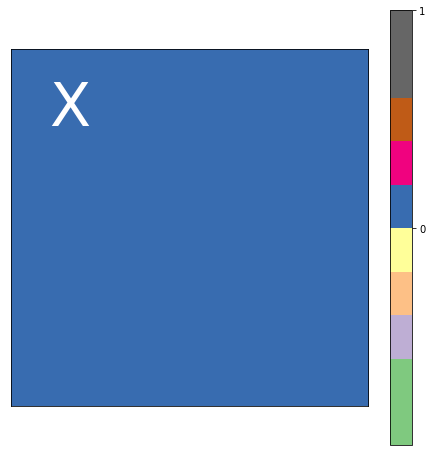

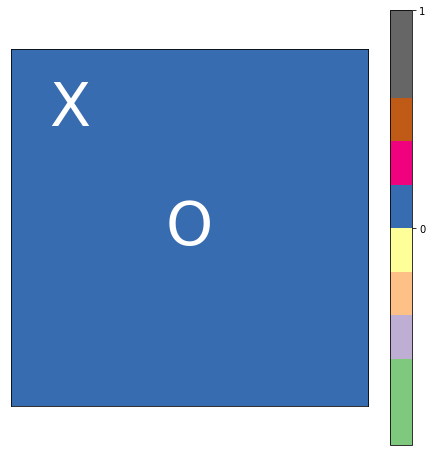

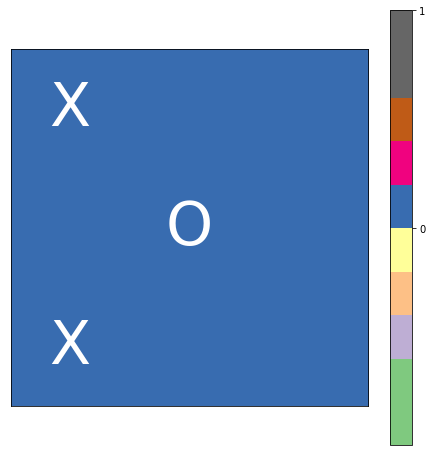

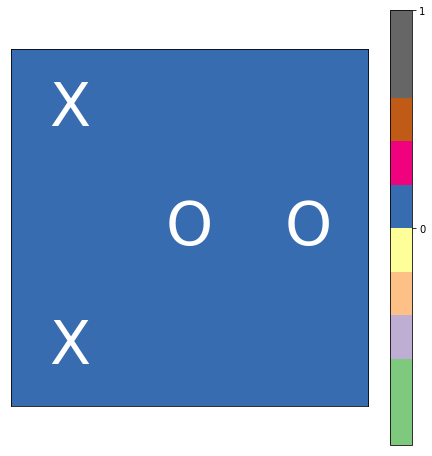

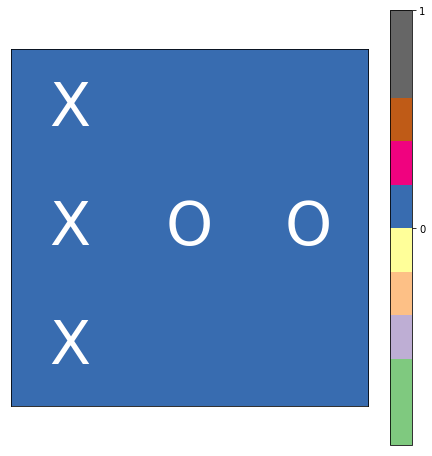

(1, 0)

In [9]:
play(env, Q, print_board=True, random_X=False, random_0=False)

In [10]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
game_hash, empty_spaces, _ = env.getState()
A = tuple(range(len(empty_spaces)))
Q = defaultdict(lambda: np.zeros(len(A)))

In [11]:
Q, (hist_X, hist_0), iters = Q_learning(env, Q, A, episodes=2000000, alpha=0.9, epsilon=0.5)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000000/2000000 [1:09:12<00:00, 481.69it/s]


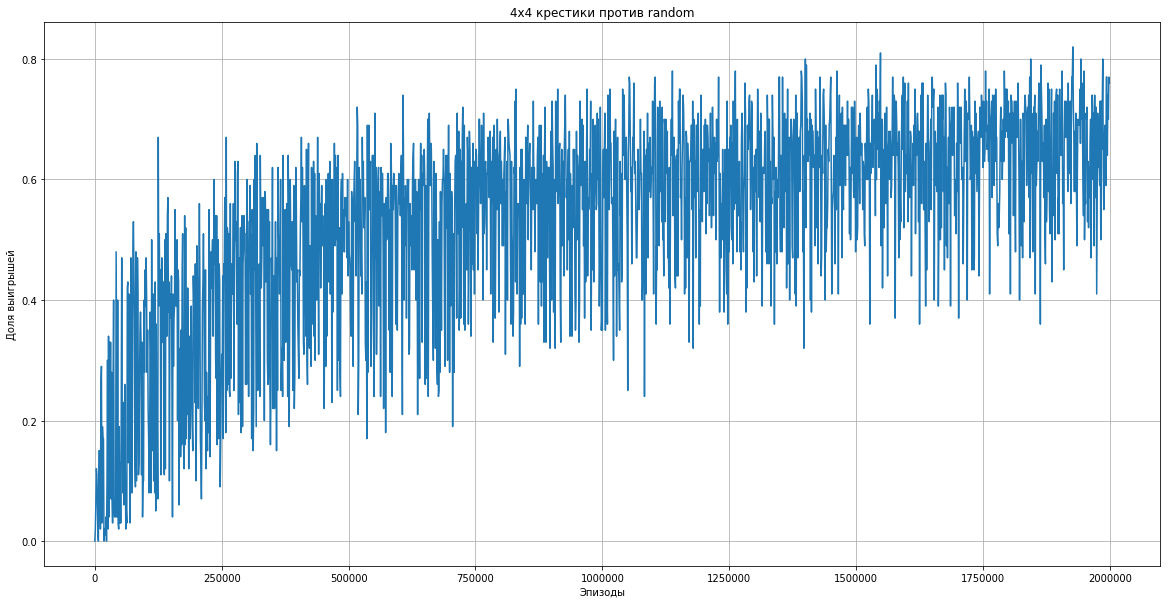

In [12]:
plt.figure(figsize=(20, 10))
plt.title('4x4 крестики против random')
plt.xlabel('Эпизоды')
plt.ylabel('Доля выигрышей')
plt.grid(True)
plt.plot(iters, hist_X);

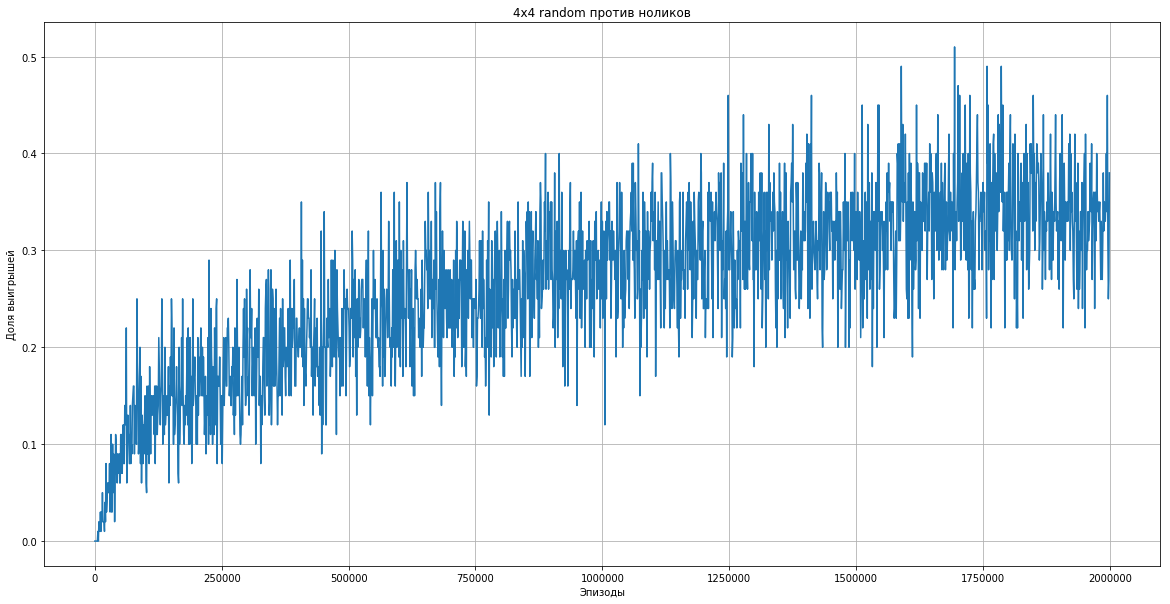

In [13]:
plt.figure(figsize=(20, 10))
plt.title('4x4 random против ноликов')
plt.xlabel('Эпизоды')
plt.ylabel('Доля выигрышей')
plt.grid(True)
plt.plot(iters, hist_0);

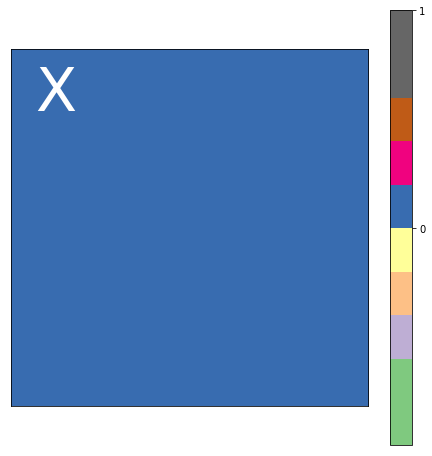

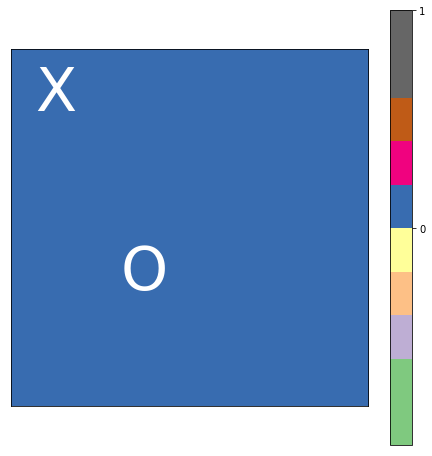

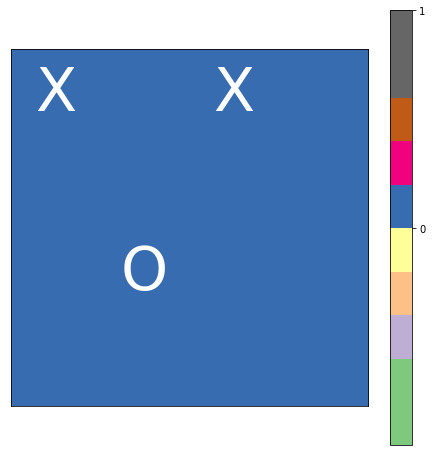

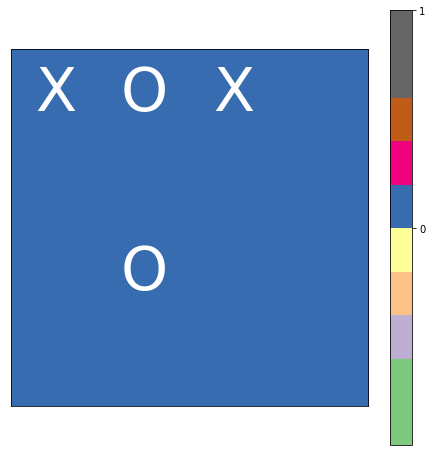

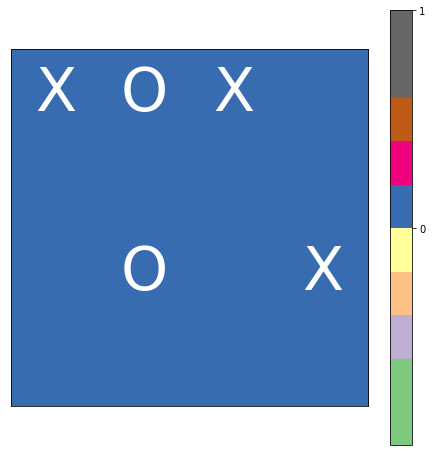

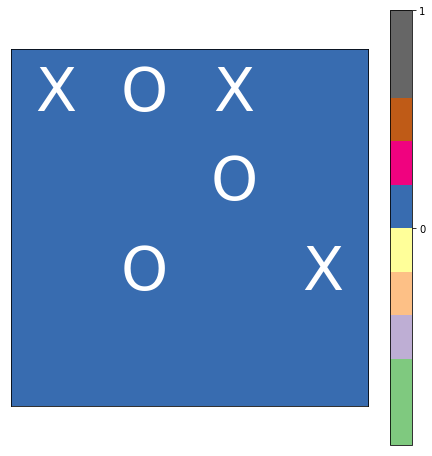

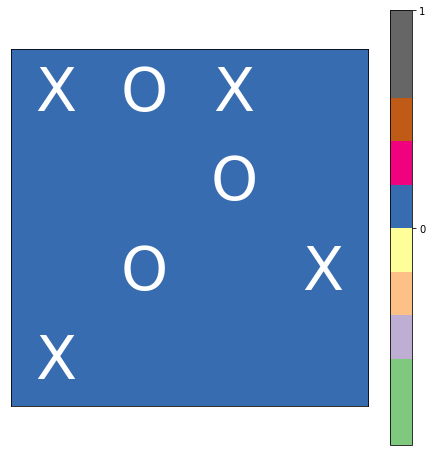

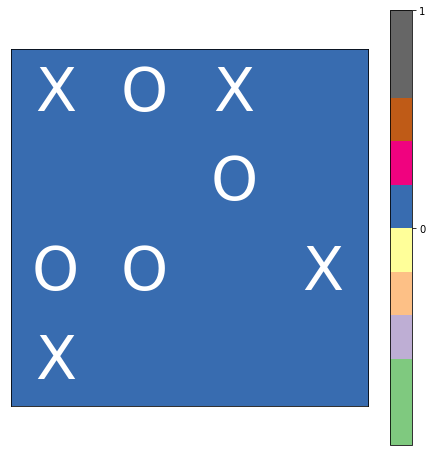

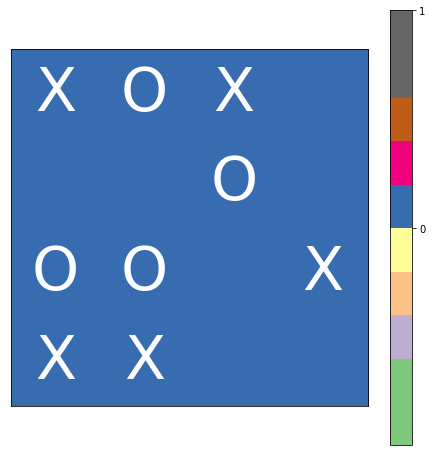

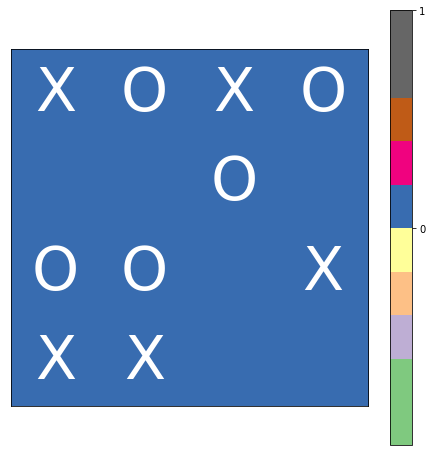

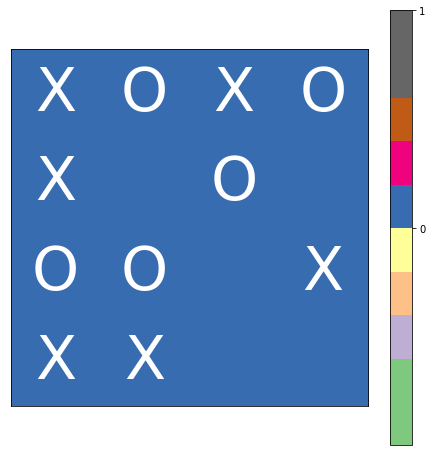

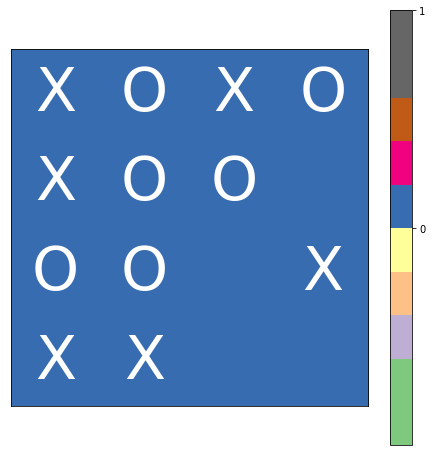

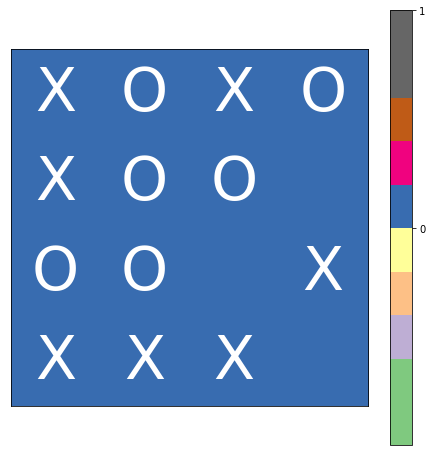

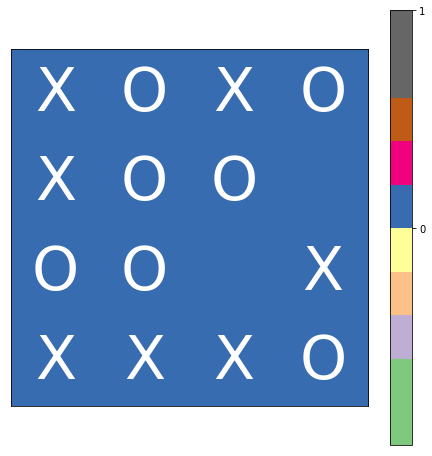

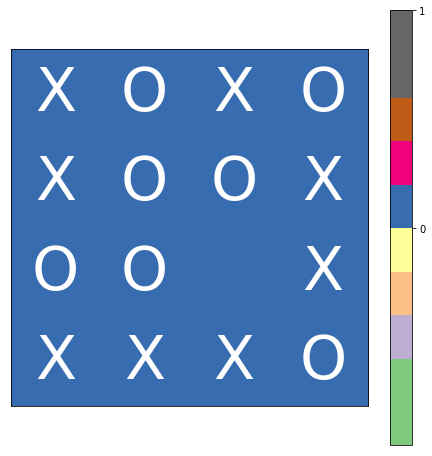

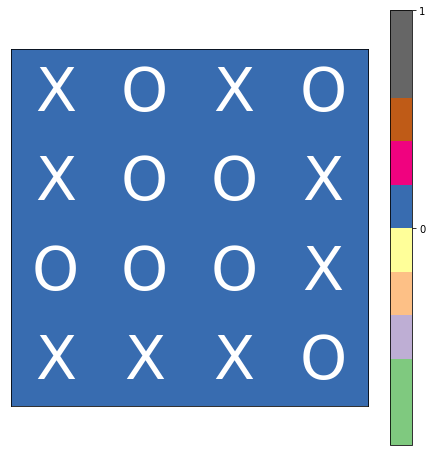

(0, 0)

In [14]:
play(env, Q, print_board=True, random_X=False, random_0=False)

In [56]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

class Player:
    def __init__(self, memory_capacity=10000):
        self.state = None
        self.action = None
        self.reward = None
        self.next_state = None
        self.memory = ReplayMemory(capacity=memory_capacity)
    
    def add_exp(self, next_state, action, reward):
        
        next_state = state_to_layers(next_state)
        if self.state is not None:
            self.memory.store((self.state, next_state, self.action, reward))
        self.state = next_state
        self.action = action
        
    def new_game(self):
        self.state = None
        self.action = None        

        
def state_to_layers(state):
    return np.array([
        (state == 1).astype(float), 
        (state == -1).astype(float), 
        (state == 0).astype(float)
    ])
        
def get_action_from_model(model, state):
    model.eval()
    state = state_to_layers(state)
    state = torch.FloatTensor([state])
    action = model(state).detach().max(1)[1][0].item()
    return action

def avail_actions(s):
    string_array = np.array(list(s))
    return np.where(string_array == '1')[0]
    
def get_action(model, state, game_hash, epsilon):
    if random.random() < (1 - epsilon):
        action = get_action_from_model(model, state)
    else:
        action = random.choice(avail_actions(game_hash))
    return action
        
def play_game_model(env, model, print_board=False, player1_random=False, player2_random=False):
    env.reset()
    game_hash, empty_spaces, turn = env.getState()
    state = env.board
    done = False
    result = [0, 0]
    player = 1
    while not done:
        
        if player == 1 and player1_random or player == -1 and player2_random:
            action = random.choice(avail_actions(game_hash))
        else:
            action =  get_action_from_model(model, state)
        action_tuple = env.action_from_int(action)
        (game_hash, empty_spaces, turn), reward, done, _ = env.step(action_tuple)
        state = env.board

        if print_board:
            plot_board(env, None)
            
        player = -player
                    
    if reward == 1:
        return (1, 0)
    elif reward == -1:
        return (0, 1)
    else:
        return (0, 0)
        
def evaluate_model(env, model, n=1000, disable_tqdm=False, player1_random=False, player2_random=False):
    model.eval()
    rewards1 = []
    rewards2 = []
    for _ in tqdm(range(n), disable=disable_tqdm):
        reward1, reward2 = play_game_model(
            env, 
            model, 
            print_board=False, 
            player1_random=player1_random, 
            player2_random=player2_random
        )
        rewards1.append(reward1)
        rewards2.append(reward2)
    r1 = np.mean(rewards1)
    r2 = np.mean(rewards2)
    no_winner = 1 - r1 - r2
    return r1, r2, no_winner

def train_batch(model, optimizer, criterion, replay_memory, batch_size=128, gamma=1):
    
    if len(replay_memory) < batch_size:
        return
    
    
    states, next_states, actions, rewards = list(zip(*replay_memory.sample(batch_size)))
    
    
    batch_state = torch.FloatTensor(states)
    batch_next_state = torch.FloatTensor(next_states)
    batch_actions = torch.LongTensor(actions)
    batch_reward = torch.FloatTensor(rewards) / 11.
    
    model.train()
    Q = model(batch_state).gather(1, batch_actions.view(-1, 1)).flatten()
    Qmax = model(batch_next_state).detach().max(dim=1)[0]
    Qnext = batch_reward + (gamma * Qmax)
    
    loss = criterion(Q, Qnext)

    
    loss.backward()
#     torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()


def play_episode(env, model1, model2, epsilon, player1, player2):
    env.reset()
    model1.eval()
    model2.eval()
    game_hash, empty_spaces, turn = env.getState()
    state = env.board.copy()
    done = False
    player1.new_game()
    player2.new_game()
    players = (player1, player2)
    models = (model1, model2)
    player_idx = 0
    
    while not done:
        player = players[player_idx]
        model = models[player_idx]
        action = get_action(model, state, game_hash, epsilon)
        player.add_exp(state, action, 0)
        player_idx = 1 - player_idx
        (game_hash, empty_spaces, turn), reward , done, _ = env.step(env.action_from_int(action))
        state = env.board.copy()
        
    if reward == -10:
        player.add_exp(state, action, reward)
    else:
        players[0].add_exp(state, action, reward)
        players[1].add_exp(state, action, -reward)
        

def run_learning(env, model1_tuple, model2_tuple, criterion, episodes=10000, eps_init=0.5, batch_size=64, gamma=1, model_name='dqn'):
    p1, p2 = Player(), Player()
    model1, optimizer1, scheduler1 = model1_tuple
    model2, optimizer2, scheduler2 = model2_tuple
    
    loss_cache_p1 = []
    loss_cache_p2 = []
    hist_p1 = []
    hist_p2 = []
    iters = []
    loss_hist_p1 = []
    loss_hist_p2 = []
    best_result_p1 = 0
    best_result_p2 = 0
    pbar = tqdm(range(episodes))
    
    eps_final = 0.05
    eps_decay = int(episodes / 2)
    
    for i in pbar:
#         eps_threshold = eps_final + (eps_init - eps_final) * math.exp(-1. * i / eps_decay)
        eps_threshold = eps_init
        for _ in range(1):
            play_episode(env, model1, model2, eps_threshold, p1, p2)
        
        loss1 = train_batch(model1, optimizer1, criterion, p1.memory, batch_size=batch_size, gamma=gamma)
        loss2 = train_batch(model2, optimizer2, criterion, p2.memory, batch_size=batch_size, gamma=gamma)
        if loss1 is not None:
            loss_cache_p1.append(loss1)
        if loss2 is not None:
            loss_cache_p2.append(loss2)
        
        if (i + 1) % 100 == 0:
            result_p1, _, _ = evaluate_model(env, model1, n=200, player1_random=False, player2_random=True, disable_tqdm=True)
            _, result_p2, _ = evaluate_model(env, model2, n=200, player1_random=True, player2_random=False, disable_tqdm=True)
            
            iters.append(i)
            hist_p1.append(result_p1)
            hist_p2.append(result_p2)
            
            mean_loss_p1 = np.mean(loss_cache_p1) if loss_cache_p1 else 0
            loss_hist_p1.append(mean_loss_p1)
            
            mean_loss_p2 = np.mean(loss_cache_p2) if loss_cache_p2 else 0
            loss_hist_p2.append(mean_loss_p2)
            
            loss_cache_p1 = []
            loss_cache_p2 = []
            
            total_result = result_p1 + result_p2
            if scheduler1 is not None:
                scheduler1.step(mean_loss_p1)
            if scheduler2 is not None:
                scheduler2.step(mean_loss_p2)
            
            pbar.set_postfix({
                'l1': mean_loss_p1, 
                'l2': mean_loss_p2, 
                'p1': result_p1, 
                'p2': result_p2, 
#                 'total': total_result,
                'eps': eps_threshold,
            })

            if best_result_p1 < result_p1:
                torch.save(model1.state_dict(), f'best_{model_name}_p1.pth')
            if best_result_p2 < result_p2:
                torch.save(model2.state_dict(), f'best_{model_name}_p2.pth')
                
    return (hist_p1, hist_p2), (loss_hist_p1, loss_hist_p2), iters 

In [76]:
seed = 42
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
BCELoss = torch.nn.BCEWithLogitsLoss()

In [77]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

In [78]:
class DQN_3x3(nn.Module):
    def __init__(self, hidden_size=512):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=hidden_size, kernel_size=(3, 3))
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 9)    
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = x.squeeze(-1).squeeze(-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [79]:
model = DQN_3x3().eval()
x = torch.randn(128, 3, 3, 3)
model(x).shape

torch.Size([128, 9])

In [80]:
LR = 1e-6
WEIGHT_DECAY = 1e-9
HIDDEN_SIZE = 512
criterion = F.l1_loss

model1 = DQN_3x3(hidden_size=HIDDEN_SIZE)
#model1.to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

model2 = DQN_3x3(hidden_size=HIDDEN_SIZE)
#model2.to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [81]:
(hist_p1, hist_p2), (loss_hist_p1, loss_hist_p2), iters = run_learning(
    env, 
    (model1, optimizer1, None), 
    (model2, optimizer2, None), 
    criterion,
    episodes=20000, 
    eps_init=0.5,
    batch_size=256,
    gamma=0.9 
)

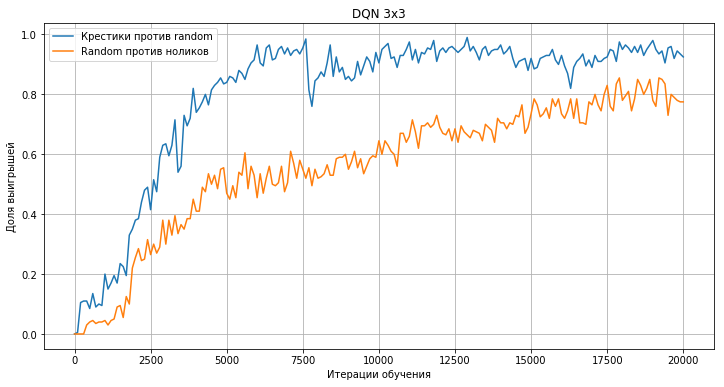

In [82]:
plt.figure(figsize=(12, 6))
plt.title('DQN 3x3')
plt.xlabel('Итерации обучения')
plt.ylabel('Доля выигрышей')
plt.grid(True)
plt.plot([0] + iters, [0] + hist_p1, label='Крестики против random')
plt.plot([0] + iters, [0] + hist_p2, label='Random против ноликов')
plt.legend();

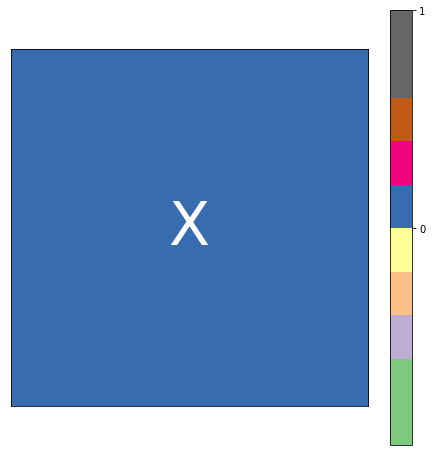

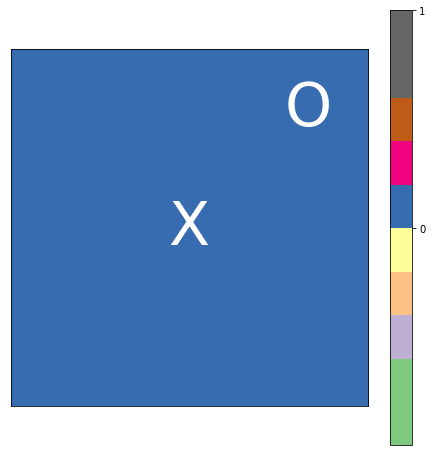

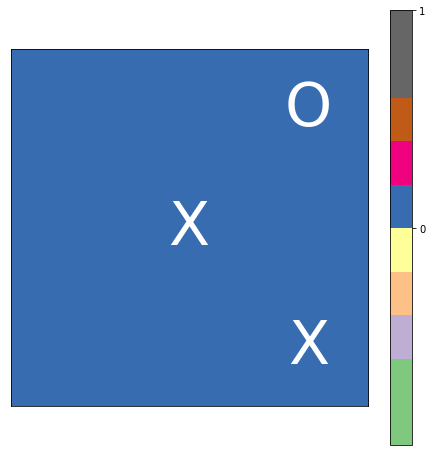

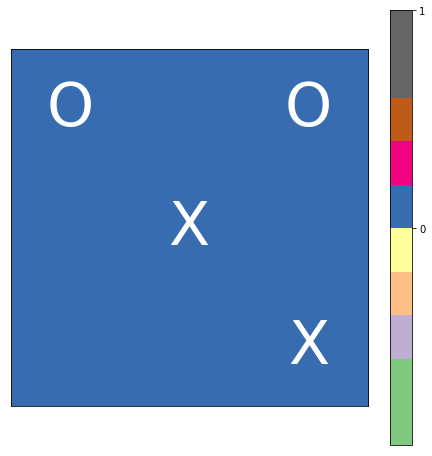

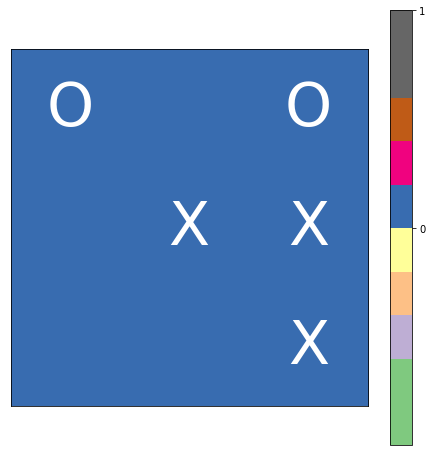

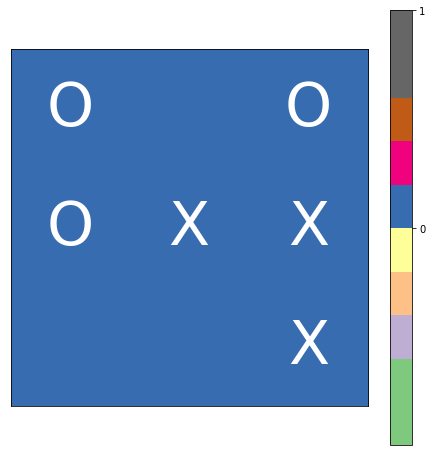

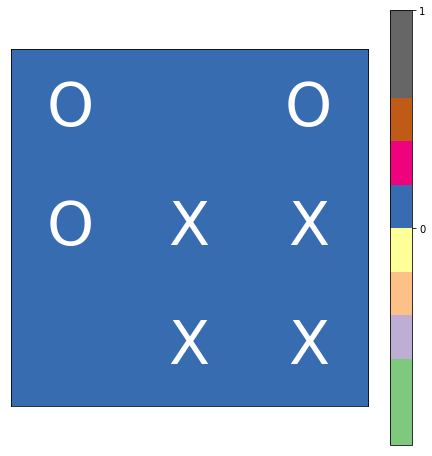

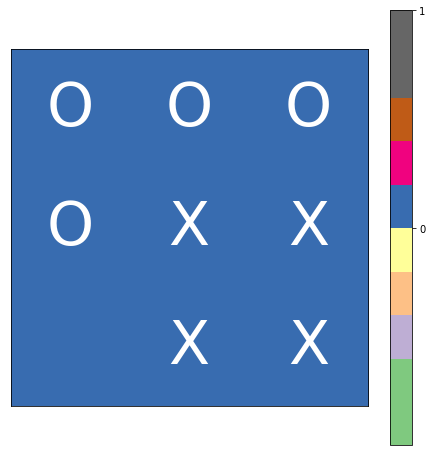

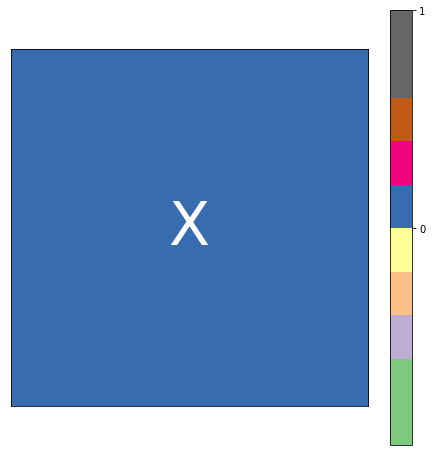

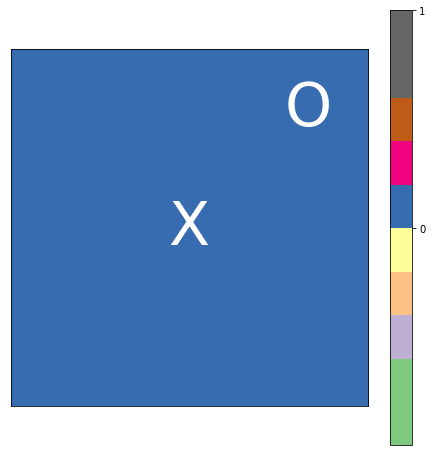

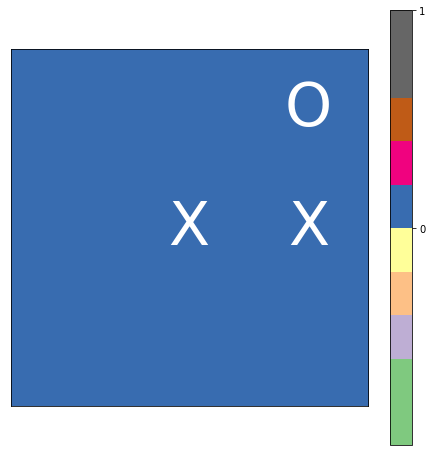

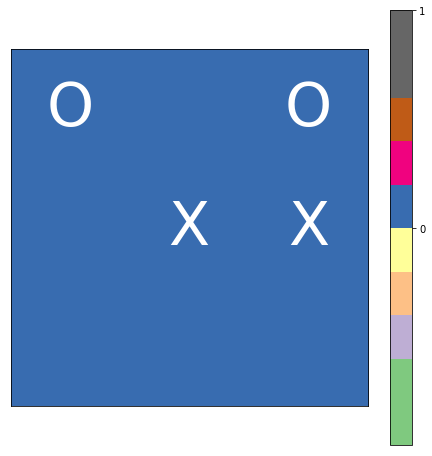

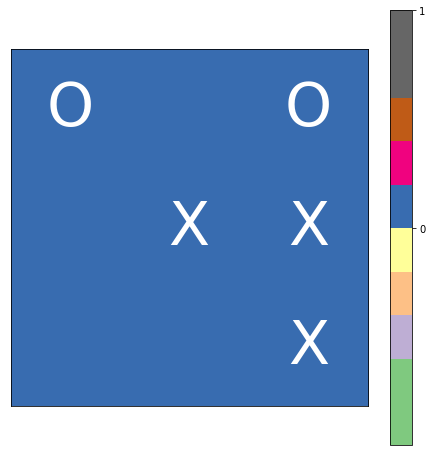

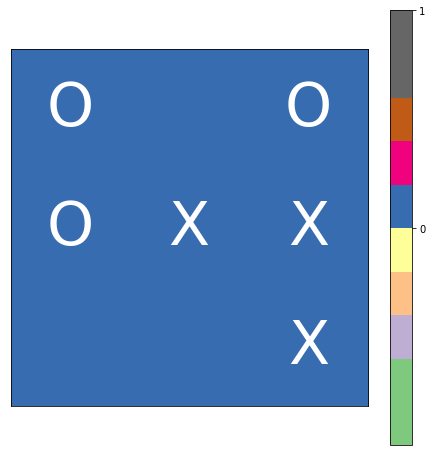

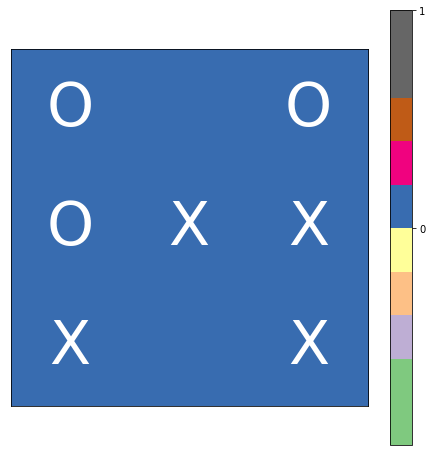

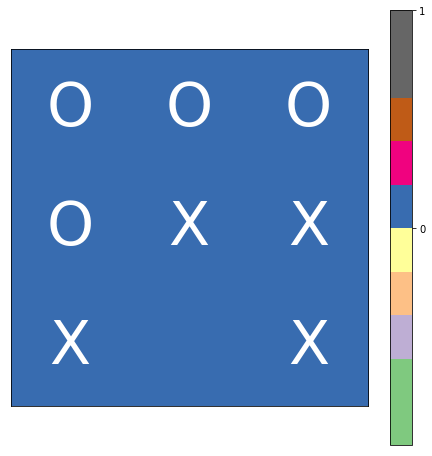

(0, 1)

In [83]:
play_game_model(env, model1, print_board=True, player1_random=False, player2_random=False)
play_game_model(env, model2, print_board=True, player1_random=False, player2_random=False)

In [65]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)

In [66]:
class DQN_4x4(nn.Module):
    def __init__(self, conv1_channels=32, conv2_channels=256):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=conv1_channels, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=(2, 2))
        self.fc1 = nn.Linear(conv2_channels, conv2_channels)
        self.fc2 = nn.Linear(conv2_channels, 16)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = x.squeeze(-1).squeeze(-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x

In [67]:
LR = 1e-5
WEIGHT_DECAY = 1e-9
criterion = F.l1_loss

model1 = DQN_4x4()
optimizer1 = optim.Adam(model1.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

model2 = DQN_4x4()
optimizer2 = optim.Adam(model2.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [68]:
(hist_p1, hist_p2), (loss_hist_p1, loss_hist_p2), iters = run_learning(
    env, 
    (model1, optimizer1, None), 
    (model2, optimizer2, None), 
    criterion,
    episodes=2000, 
    eps_init=0.5,
    batch_size=256,
    gamma=0.9, 
)






  0%|                                                                                                                                                           | 0/2000 [00:00<?, ?it/s]




  1%|█▍                                                                                                                                               | 19/2000 [00:00<00:10, 183.15it/s]




  2%|███▏                                                                                                                                             | 44/2000 [00:00<00:09, 198.79it/s]




  3%|████▋                                                                                                                                            | 64/2000 [00:00<00:09, 194.66it/s]




  4%|██████▎                                                                                                                                          | 87/2000 [00:00<00:09, 199.96it/s]




  4%|████▊                                   

  9%|█████████▊                                                                                                      | 175/2000 [00:29<16:43,  1.82it/s, l1=0, l2=0, p1=0, p2=0, eps=0.5]




  9%|█████████▊                                                                                                      | 176/2000 [00:30<17:02,  1.78it/s, l1=0, l2=0, p1=0, p2=0, eps=0.5]




  9%|█████████▉                                                                                                      | 177/2000 [00:30<16:54,  1.80it/s, l1=0, l2=0, p1=0, p2=0, eps=0.5]




  9%|█████████▉                                                                                                      | 178/2000 [00:31<16:53,  1.80it/s, l1=0, l2=0, p1=0, p2=0, eps=0.5]




  9%|██████████                                                                                                      | 179/2000 [00:31<16:29,  1.84it/s, l1=0, l2=0, p1=0, p2=0, eps=0.5]




  9%|██████████                                   

 11%|███████████▎                                                                                            | 217/2000 [00:54<16:15,  1.83it/s, l1=0.231, l2=0.271, p1=0, p2=0, eps=0.5]




 11%|███████████▎                                                                                            | 218/2000 [00:55<16:22,  1.81it/s, l1=0.231, l2=0.271, p1=0, p2=0, eps=0.5]




 11%|███████████▍                                                                                            | 219/2000 [00:55<16:23,  1.81it/s, l1=0.231, l2=0.271, p1=0, p2=0, eps=0.5]




 11%|███████████▍                                                                                            | 220/2000 [00:56<16:28,  1.80it/s, l1=0.231, l2=0.271, p1=0, p2=0, eps=0.5]




 11%|███████████▍                                                                                            | 221/2000 [00:56<16:34,  1.79it/s, l1=0.231, l2=0.271, p1=0, p2=0, eps=0.5]




 11%|███████████▌                                 

 13%|█████████████▌                                                                                          | 260/2000 [01:17<15:53,  1.82it/s, l1=0.231, l2=0.271, p1=0, p2=0, eps=0.5]




 13%|█████████████▌                                                                                          | 261/2000 [01:18<16:11,  1.79it/s, l1=0.231, l2=0.271, p1=0, p2=0, eps=0.5]




 13%|█████████████▌                                                                                          | 262/2000 [01:19<16:30,  1.75it/s, l1=0.231, l2=0.271, p1=0, p2=0, eps=0.5]




 13%|█████████████▋                                                                                          | 263/2000 [01:19<16:29,  1.75it/s, l1=0.231, l2=0.271, p1=0, p2=0, eps=0.5]




 13%|█████████████▋                                                                                          | 264/2000 [01:20<16:39,  1.74it/s, l1=0.231, l2=0.271, p1=0, p2=0, eps=0.5]




 13%|█████████████▊                               

 15%|███████████████▎                                                                                     | 302/2000 [01:43<24:59,  1.13it/s, l1=0.214, l2=0.224, p1=0.01, p2=0, eps=0.5]




 15%|███████████████▎                                                                                     | 303/2000 [01:44<22:23,  1.26it/s, l1=0.214, l2=0.224, p1=0.01, p2=0, eps=0.5]




 15%|███████████████▎                                                                                     | 304/2000 [01:44<20:20,  1.39it/s, l1=0.214, l2=0.224, p1=0.01, p2=0, eps=0.5]




 15%|███████████████▍                                                                                     | 305/2000 [01:45<18:41,  1.51it/s, l1=0.214, l2=0.224, p1=0.01, p2=0, eps=0.5]




 15%|███████████████▍                                                                                     | 306/2000 [01:45<17:37,  1.60it/s, l1=0.214, l2=0.224, p1=0.01, p2=0, eps=0.5]




 15%|███████████████▌                             

 17%|█████████████████▍                                                                                   | 345/2000 [02:06<14:21,  1.92it/s, l1=0.214, l2=0.224, p1=0.01, p2=0, eps=0.5]




 17%|█████████████████▍                                                                                   | 346/2000 [02:07<14:21,  1.92it/s, l1=0.214, l2=0.224, p1=0.01, p2=0, eps=0.5]




 17%|█████████████████▌                                                                                   | 347/2000 [02:08<14:14,  1.94it/s, l1=0.214, l2=0.224, p1=0.01, p2=0, eps=0.5]




 17%|█████████████████▌                                                                                   | 348/2000 [02:08<14:18,  1.92it/s, l1=0.214, l2=0.224, p1=0.01, p2=0, eps=0.5]




 17%|█████████████████▌                                                                                   | 349/2000 [02:09<14:23,  1.91it/s, l1=0.214, l2=0.224, p1=0.01, p2=0, eps=0.5]




 18%|█████████████████▋                           

 19%|███████████████████▌                                                                                 | 388/2000 [02:30<14:49,  1.81it/s, l1=0.214, l2=0.224, p1=0.01, p2=0, eps=0.5]




 19%|███████████████████▋                                                                                 | 389/2000 [02:30<15:00,  1.79it/s, l1=0.214, l2=0.224, p1=0.01, p2=0, eps=0.5]




 20%|███████████████████▋                                                                                 | 390/2000 [02:31<14:52,  1.80it/s, l1=0.214, l2=0.224, p1=0.01, p2=0, eps=0.5]




 20%|███████████████████▋                                                                                 | 391/2000 [02:32<15:07,  1.77it/s, l1=0.214, l2=0.224, p1=0.01, p2=0, eps=0.5]




 20%|███████████████████▊                                                                                 | 392/2000 [02:32<15:02,  1.78it/s, l1=0.214, l2=0.224, p1=0.01, p2=0, eps=0.5]




 20%|███████████████████▊                         

 22%|██████████████████████▎                                                                                 | 430/2000 [02:55<14:24,  1.82it/s, l1=0.191, l2=0.186, p1=0, p2=0, eps=0.5]




 22%|██████████████████████▍                                                                                 | 431/2000 [02:55<14:16,  1.83it/s, l1=0.191, l2=0.186, p1=0, p2=0, eps=0.5]




 22%|██████████████████████▍                                                                                 | 432/2000 [02:56<14:27,  1.81it/s, l1=0.191, l2=0.186, p1=0, p2=0, eps=0.5]




 22%|██████████████████████▌                                                                                 | 433/2000 [02:57<14:30,  1.80it/s, l1=0.191, l2=0.186, p1=0, p2=0, eps=0.5]




 22%|██████████████████████▌                                                                                 | 434/2000 [02:57<14:44,  1.77it/s, l1=0.191, l2=0.186, p1=0, p2=0, eps=0.5]




 22%|██████████████████████▌                      

 24%|████████████████████████▌                                                                               | 473/2000 [03:19<14:33,  1.75it/s, l1=0.191, l2=0.186, p1=0, p2=0, eps=0.5]




 24%|████████████████████████▋                                                                               | 474/2000 [03:20<14:33,  1.75it/s, l1=0.191, l2=0.186, p1=0, p2=0, eps=0.5]




 24%|████████████████████████▋                                                                               | 475/2000 [03:20<14:26,  1.76it/s, l1=0.191, l2=0.186, p1=0, p2=0, eps=0.5]




 24%|████████████████████████▊                                                                               | 476/2000 [03:21<14:28,  1.75it/s, l1=0.191, l2=0.186, p1=0, p2=0, eps=0.5]




 24%|████████████████████████▊                                                                               | 477/2000 [03:21<14:40,  1.73it/s, l1=0.191, l2=0.186, p1=0, p2=0, eps=0.5]




 24%|████████████████████████▊                    

 26%|█████████████████████████▊                                                                          | 515/2000 [03:45<14:12,  1.74it/s, l1=0.181, l2=0.172, p1=0.005, p2=0, eps=0.5]




 26%|█████████████████████████▊                                                                          | 516/2000 [03:45<14:20,  1.73it/s, l1=0.181, l2=0.172, p1=0.005, p2=0, eps=0.5]




 26%|█████████████████████████▊                                                                          | 517/2000 [03:46<14:36,  1.69it/s, l1=0.181, l2=0.172, p1=0.005, p2=0, eps=0.5]




 26%|█████████████████████████▉                                                                          | 518/2000 [03:47<14:39,  1.69it/s, l1=0.181, l2=0.172, p1=0.005, p2=0, eps=0.5]




 26%|█████████████████████████▉                                                                          | 519/2000 [03:47<14:39,  1.68it/s, l1=0.181, l2=0.172, p1=0.005, p2=0, eps=0.5]




 26%|██████████████████████████                   

 28%|███████████████████████████▉                                                                        | 558/2000 [04:09<12:57,  1.85it/s, l1=0.181, l2=0.172, p1=0.005, p2=0, eps=0.5]




 28%|███████████████████████████▉                                                                        | 559/2000 [04:09<13:09,  1.83it/s, l1=0.181, l2=0.172, p1=0.005, p2=0, eps=0.5]




 28%|████████████████████████████                                                                        | 560/2000 [04:10<13:18,  1.80it/s, l1=0.181, l2=0.172, p1=0.005, p2=0, eps=0.5]




 28%|████████████████████████████                                                                        | 561/2000 [04:11<13:22,  1.79it/s, l1=0.181, l2=0.172, p1=0.005, p2=0, eps=0.5]




 28%|████████████████████████████                                                                        | 562/2000 [04:11<13:18,  1.80it/s, l1=0.181, l2=0.172, p1=0.005, p2=0, eps=0.5]




 28%|████████████████████████████▏                

 30%|██████████████████████████████▎                                                                      | 600/2000 [04:34<28:07,  1.21s/it, l1=0.166, l2=0.159, p1=0.03, p2=0, eps=0.5]




 30%|██████████████████████████████▎                                                                      | 601/2000 [04:35<23:11,  1.01it/s, l1=0.166, l2=0.159, p1=0.03, p2=0, eps=0.5]




 30%|██████████████████████████████▍                                                                      | 602/2000 [04:35<20:15,  1.15it/s, l1=0.166, l2=0.159, p1=0.03, p2=0, eps=0.5]




 30%|██████████████████████████████▍                                                                      | 603/2000 [04:36<18:07,  1.28it/s, l1=0.166, l2=0.159, p1=0.03, p2=0, eps=0.5]




 30%|██████████████████████████████▌                                                                      | 604/2000 [04:37<16:22,  1.42it/s, l1=0.166, l2=0.159, p1=0.03, p2=0, eps=0.5]




 30%|██████████████████████████████▌              

 32%|████████████████████████████████▍                                                                    | 643/2000 [04:58<12:31,  1.81it/s, l1=0.166, l2=0.159, p1=0.03, p2=0, eps=0.5]




 32%|████████████████████████████████▌                                                                    | 644/2000 [04:59<12:40,  1.78it/s, l1=0.166, l2=0.159, p1=0.03, p2=0, eps=0.5]




 32%|████████████████████████████████▌                                                                    | 645/2000 [04:59<12:59,  1.74it/s, l1=0.166, l2=0.159, p1=0.03, p2=0, eps=0.5]




 32%|████████████████████████████████▌                                                                    | 646/2000 [05:00<13:16,  1.70it/s, l1=0.166, l2=0.159, p1=0.03, p2=0, eps=0.5]




 32%|████████████████████████████████▋                                                                    | 647/2000 [05:00<13:00,  1.73it/s, l1=0.166, l2=0.159, p1=0.03, p2=0, eps=0.5]




 32%|████████████████████████████████▋            

 34%|██████████████████████████████████▋                                                                  | 686/2000 [05:22<11:46,  1.86it/s, l1=0.166, l2=0.159, p1=0.03, p2=0, eps=0.5]




 34%|██████████████████████████████████▋                                                                  | 687/2000 [05:22<12:01,  1.82it/s, l1=0.166, l2=0.159, p1=0.03, p2=0, eps=0.5]




 34%|██████████████████████████████████▋                                                                  | 688/2000 [05:23<12:02,  1.82it/s, l1=0.166, l2=0.159, p1=0.03, p2=0, eps=0.5]




 34%|██████████████████████████████████▊                                                                  | 689/2000 [05:23<12:04,  1.81it/s, l1=0.166, l2=0.159, p1=0.03, p2=0, eps=0.5]




 34%|██████████████████████████████████▊                                                                  | 690/2000 [05:24<11:47,  1.85it/s, l1=0.166, l2=0.159, p1=0.03, p2=0, eps=0.5]




 35%|██████████████████████████████████▉          

 36%|██████████████████████████████████▉                                                             | 728/2000 [05:47<11:45,  1.80it/s, l1=0.156, l2=0.153, p1=0.005, p2=0.005, eps=0.5]




 36%|██████████████████████████████████▉                                                             | 729/2000 [05:48<11:50,  1.79it/s, l1=0.156, l2=0.153, p1=0.005, p2=0.005, eps=0.5]




 36%|███████████████████████████████████                                                             | 730/2000 [05:48<11:40,  1.81it/s, l1=0.156, l2=0.153, p1=0.005, p2=0.005, eps=0.5]




 37%|███████████████████████████████████                                                             | 731/2000 [05:49<11:41,  1.81it/s, l1=0.156, l2=0.153, p1=0.005, p2=0.005, eps=0.5]




 37%|███████████████████████████████████▏                                                            | 732/2000 [05:49<11:24,  1.85it/s, l1=0.156, l2=0.153, p1=0.005, p2=0.005, eps=0.5]




 37%|███████████████████████████████████▏         

 39%|█████████████████████████████████████                                                           | 771/2000 [06:12<11:43,  1.75it/s, l1=0.156, l2=0.153, p1=0.005, p2=0.005, eps=0.5]




 39%|█████████████████████████████████████                                                           | 772/2000 [06:12<11:58,  1.71it/s, l1=0.156, l2=0.153, p1=0.005, p2=0.005, eps=0.5]




 39%|█████████████████████████████████████                                                           | 773/2000 [06:13<12:02,  1.70it/s, l1=0.156, l2=0.153, p1=0.005, p2=0.005, eps=0.5]




 39%|█████████████████████████████████████▏                                                          | 774/2000 [06:13<11:58,  1.71it/s, l1=0.156, l2=0.153, p1=0.005, p2=0.005, eps=0.5]




 39%|█████████████████████████████████████▏                                                          | 775/2000 [06:14<11:55,  1.71it/s, l1=0.156, l2=0.153, p1=0.005, p2=0.005, eps=0.5]




 39%|█████████████████████████████████████▏       

 41%|███████████████████████████████████████                                                         | 813/2000 [06:38<10:49,  1.83it/s, l1=0.146, l2=0.151, p1=0.015, p2=0.015, eps=0.5]




 41%|███████████████████████████████████████                                                         | 814/2000 [06:38<10:47,  1.83it/s, l1=0.146, l2=0.151, p1=0.015, p2=0.015, eps=0.5]




 41%|███████████████████████████████████████                                                         | 815/2000 [06:39<10:46,  1.83it/s, l1=0.146, l2=0.151, p1=0.015, p2=0.015, eps=0.5]




 41%|███████████████████████████████████████▏                                                        | 816/2000 [06:39<10:39,  1.85it/s, l1=0.146, l2=0.151, p1=0.015, p2=0.015, eps=0.5]




 41%|███████████████████████████████████████▏                                                        | 817/2000 [06:40<10:28,  1.88it/s, l1=0.146, l2=0.151, p1=0.015, p2=0.015, eps=0.5]




 41%|███████████████████████████████████████▎     

 43%|█████████████████████████████████████████                                                       | 856/2000 [07:01<10:14,  1.86it/s, l1=0.146, l2=0.151, p1=0.015, p2=0.015, eps=0.5]




 43%|█████████████████████████████████████████▏                                                      | 857/2000 [07:02<10:18,  1.85it/s, l1=0.146, l2=0.151, p1=0.015, p2=0.015, eps=0.5]




 43%|█████████████████████████████████████████▏                                                      | 858/2000 [07:02<10:14,  1.86it/s, l1=0.146, l2=0.151, p1=0.015, p2=0.015, eps=0.5]




 43%|█████████████████████████████████████████▏                                                      | 859/2000 [07:03<10:08,  1.87it/s, l1=0.146, l2=0.151, p1=0.015, p2=0.015, eps=0.5]




 43%|█████████████████████████████████████████▎                                                      | 860/2000 [07:03<10:08,  1.87it/s, l1=0.146, l2=0.151, p1=0.015, p2=0.015, eps=0.5]




 43%|█████████████████████████████████████████▎   

 45%|███████████████████████████████████████████▏                                                    | 899/2000 [07:25<09:47,  1.88it/s, l1=0.146, l2=0.151, p1=0.015, p2=0.015, eps=0.5]




 45%|███████████████████████████████████████████▌                                                     | 899/2000 [07:29<09:47,  1.88it/s, l1=0.144, l2=0.145, p1=0.01, p2=0.005, eps=0.5]




 45%|███████████████████████████████████████████▋                                                     | 900/2000 [07:29<26:46,  1.46s/it, l1=0.144, l2=0.145, p1=0.01, p2=0.005, eps=0.5]




 45%|███████████████████████████████████████████▋                                                     | 901/2000 [07:29<21:29,  1.17s/it, l1=0.144, l2=0.145, p1=0.01, p2=0.005, eps=0.5]




 45%|███████████████████████████████████████████▋                                                     | 902/2000 [07:30<17:50,  1.03it/s, l1=0.144, l2=0.145, p1=0.01, p2=0.005, eps=0.5]




 45%|███████████████████████████████████████████▊ 

 47%|█████████████████████████████████████████████▋                                                   | 941/2000 [07:51<09:08,  1.93it/s, l1=0.144, l2=0.145, p1=0.01, p2=0.005, eps=0.5]




 47%|█████████████████████████████████████████████▋                                                   | 942/2000 [07:52<09:15,  1.91it/s, l1=0.144, l2=0.145, p1=0.01, p2=0.005, eps=0.5]




 47%|█████████████████████████████████████████████▋                                                   | 943/2000 [07:52<09:25,  1.87it/s, l1=0.144, l2=0.145, p1=0.01, p2=0.005, eps=0.5]




 47%|█████████████████████████████████████████████▊                                                   | 944/2000 [07:53<09:41,  1.81it/s, l1=0.144, l2=0.145, p1=0.01, p2=0.005, eps=0.5]




 47%|█████████████████████████████████████████████▊                                                   | 945/2000 [07:53<09:43,  1.81it/s, l1=0.144, l2=0.145, p1=0.01, p2=0.005, eps=0.5]




 47%|█████████████████████████████████████████████

 49%|███████████████████████████████████████████████▋                                                 | 984/2000 [08:15<09:23,  1.80it/s, l1=0.144, l2=0.145, p1=0.01, p2=0.005, eps=0.5]




 49%|███████████████████████████████████████████████▊                                                 | 985/2000 [08:16<09:11,  1.84it/s, l1=0.144, l2=0.145, p1=0.01, p2=0.005, eps=0.5]




 49%|███████████████████████████████████████████████▊                                                 | 986/2000 [08:16<09:15,  1.83it/s, l1=0.144, l2=0.145, p1=0.01, p2=0.005, eps=0.5]




 49%|███████████████████████████████████████████████▊                                                 | 987/2000 [08:17<09:17,  1.82it/s, l1=0.144, l2=0.145, p1=0.01, p2=0.005, eps=0.5]




 49%|███████████████████████████████████████████████▉                                                 | 988/2000 [08:17<09:16,  1.82it/s, l1=0.144, l2=0.145, p1=0.01, p2=0.005, eps=0.5]




 49%|█████████████████████████████████████████████

 51%|█████████████████████████████████████████████████▏                                              | 1026/2000 [08:41<09:01,  1.80it/s, l1=0.137, l2=0.139, p1=0.005, p2=0.01, eps=0.5]




 51%|█████████████████████████████████████████████████▎                                              | 1027/2000 [08:42<08:50,  1.83it/s, l1=0.137, l2=0.139, p1=0.005, p2=0.01, eps=0.5]




 51%|█████████████████████████████████████████████████▎                                              | 1028/2000 [08:42<08:51,  1.83it/s, l1=0.137, l2=0.139, p1=0.005, p2=0.01, eps=0.5]




 51%|█████████████████████████████████████████████████▍                                              | 1029/2000 [08:43<09:00,  1.80it/s, l1=0.137, l2=0.139, p1=0.005, p2=0.01, eps=0.5]




 52%|█████████████████████████████████████████████████▍                                              | 1030/2000 [08:43<09:03,  1.78it/s, l1=0.137, l2=0.139, p1=0.005, p2=0.01, eps=0.5]




 52%|█████████████████████████████████████████████

 53%|███████████████████████████████████████████████████▎                                            | 1069/2000 [09:05<08:20,  1.86it/s, l1=0.137, l2=0.139, p1=0.005, p2=0.01, eps=0.5]




 54%|███████████████████████████████████████████████████▎                                            | 1070/2000 [09:05<08:23,  1.85it/s, l1=0.137, l2=0.139, p1=0.005, p2=0.01, eps=0.5]




 54%|███████████████████████████████████████████████████▍                                            | 1071/2000 [09:06<08:16,  1.87it/s, l1=0.137, l2=0.139, p1=0.005, p2=0.01, eps=0.5]




 54%|███████████████████████████████████████████████████▍                                            | 1072/2000 [09:06<08:27,  1.83it/s, l1=0.137, l2=0.139, p1=0.005, p2=0.01, eps=0.5]




 54%|███████████████████████████████████████████████████▌                                            | 1073/2000 [09:07<08:28,  1.82it/s, l1=0.137, l2=0.139, p1=0.005, p2=0.01, eps=0.5]




 54%|█████████████████████████████████████████████

 56%|████████████████████████████████████████████████████▊                                          | 1111/2000 [09:32<08:31,  1.74it/s, l1=0.131, l2=0.133, p1=0.035, p2=0.035, eps=0.5]




 56%|████████████████████████████████████████████████████▊                                          | 1112/2000 [09:33<08:27,  1.75it/s, l1=0.131, l2=0.133, p1=0.035, p2=0.035, eps=0.5]




 56%|████████████████████████████████████████████████████▊                                          | 1113/2000 [09:33<08:24,  1.76it/s, l1=0.131, l2=0.133, p1=0.035, p2=0.035, eps=0.5]




 56%|████████████████████████████████████████████████████▉                                          | 1114/2000 [09:34<08:18,  1.78it/s, l1=0.131, l2=0.133, p1=0.035, p2=0.035, eps=0.5]




 56%|████████████████████████████████████████████████████▉                                          | 1115/2000 [09:34<08:13,  1.79it/s, l1=0.131, l2=0.133, p1=0.035, p2=0.035, eps=0.5]




 56%|█████████████████████████████████████████████

 58%|██████████████████████████████████████████████████████▊                                        | 1154/2000 [09:56<07:58,  1.77it/s, l1=0.131, l2=0.133, p1=0.035, p2=0.035, eps=0.5]




 58%|██████████████████████████████████████████████████████▊                                        | 1155/2000 [09:57<07:50,  1.80it/s, l1=0.131, l2=0.133, p1=0.035, p2=0.035, eps=0.5]




 58%|██████████████████████████████████████████████████████▉                                        | 1156/2000 [09:57<07:52,  1.78it/s, l1=0.131, l2=0.133, p1=0.035, p2=0.035, eps=0.5]




 58%|██████████████████████████████████████████████████████▉                                        | 1157/2000 [09:58<07:58,  1.76it/s, l1=0.131, l2=0.133, p1=0.035, p2=0.035, eps=0.5]




 58%|███████████████████████████████████████████████████████                                        | 1158/2000 [09:58<08:01,  1.75it/s, l1=0.131, l2=0.133, p1=0.035, p2=0.035, eps=0.5]




 58%|█████████████████████████████████████████████

 60%|████████████████████████████████████████████████████████▊                                      | 1197/2000 [10:20<07:35,  1.76it/s, l1=0.131, l2=0.133, p1=0.035, p2=0.035, eps=0.5]




 60%|████████████████████████████████████████████████████████▉                                      | 1198/2000 [10:21<07:31,  1.78it/s, l1=0.131, l2=0.133, p1=0.035, p2=0.035, eps=0.5]




 60%|████████████████████████████████████████████████████████▉                                      | 1199/2000 [10:21<07:32,  1.77it/s, l1=0.131, l2=0.133, p1=0.035, p2=0.035, eps=0.5]




 60%|██████████████████████████████████████████████████████████▊                                       | 1199/2000 [10:25<07:32,  1.77it/s, l1=0.126, l2=0.13, p1=0.05, p2=0.06, eps=0.5]




 60%|██████████████████████████████████████████████████████████▊                                       | 1200/2000 [10:25<19:25,  1.46s/it, l1=0.126, l2=0.13, p1=0.05, p2=0.06, eps=0.5]




 60%|█████████████████████████████████████████████

 62%|████████████████████████████████████████████████████████████▋                                     | 1239/2000 [10:47<06:52,  1.84it/s, l1=0.126, l2=0.13, p1=0.05, p2=0.06, eps=0.5]




 62%|████████████████████████████████████████████████████████████▊                                     | 1240/2000 [10:48<06:51,  1.85it/s, l1=0.126, l2=0.13, p1=0.05, p2=0.06, eps=0.5]




 62%|████████████████████████████████████████████████████████████▊                                     | 1241/2000 [10:48<07:01,  1.80it/s, l1=0.126, l2=0.13, p1=0.05, p2=0.06, eps=0.5]




 62%|████████████████████████████████████████████████████████████▊                                     | 1242/2000 [10:49<06:59,  1.81it/s, l1=0.126, l2=0.13, p1=0.05, p2=0.06, eps=0.5]




 62%|████████████████████████████████████████████████████████████▉                                     | 1243/2000 [10:49<06:54,  1.82it/s, l1=0.126, l2=0.13, p1=0.05, p2=0.06, eps=0.5]




 62%|█████████████████████████████████████████████

 64%|██████████████████████████████████████████████████████████████▊                                   | 1282/2000 [11:10<06:35,  1.81it/s, l1=0.126, l2=0.13, p1=0.05, p2=0.06, eps=0.5]




 64%|██████████████████████████████████████████████████████████████▊                                   | 1283/2000 [11:11<06:27,  1.85it/s, l1=0.126, l2=0.13, p1=0.05, p2=0.06, eps=0.5]




 64%|██████████████████████████████████████████████████████████████▉                                   | 1284/2000 [11:12<06:27,  1.85it/s, l1=0.126, l2=0.13, p1=0.05, p2=0.06, eps=0.5]




 64%|██████████████████████████████████████████████████████████████▉                                   | 1285/2000 [11:12<06:24,  1.86it/s, l1=0.126, l2=0.13, p1=0.05, p2=0.06, eps=0.5]




 64%|███████████████████████████████████████████████████████████████                                   | 1286/2000 [11:13<06:27,  1.84it/s, l1=0.126, l2=0.13, p1=0.05, p2=0.06, eps=0.5]




 64%|█████████████████████████████████████████████

 66%|███████████████████████████████████████████████████████████████▌                                | 1324/2000 [11:38<06:15,  1.80it/s, l1=0.119, l2=0.128, p1=0.065, p2=0.05, eps=0.5]




 66%|███████████████████████████████████████████████████████████████▌                                | 1325/2000 [11:39<06:18,  1.78it/s, l1=0.119, l2=0.128, p1=0.065, p2=0.05, eps=0.5]




 66%|███████████████████████████████████████████████████████████████▋                                | 1326/2000 [11:40<06:27,  1.74it/s, l1=0.119, l2=0.128, p1=0.065, p2=0.05, eps=0.5]




 66%|███████████████████████████████████████████████████████████████▋                                | 1327/2000 [11:40<06:33,  1.71it/s, l1=0.119, l2=0.128, p1=0.065, p2=0.05, eps=0.5]




 66%|███████████████████████████████████████████████████████████████▋                                | 1328/2000 [11:41<06:37,  1.69it/s, l1=0.119, l2=0.128, p1=0.065, p2=0.05, eps=0.5]




 66%|█████████████████████████████████████████████

 68%|█████████████████████████████████████████████████████████████████▌                              | 1367/2000 [12:02<05:44,  1.84it/s, l1=0.119, l2=0.128, p1=0.065, p2=0.05, eps=0.5]




 68%|█████████████████████████████████████████████████████████████████▋                              | 1368/2000 [12:03<05:44,  1.83it/s, l1=0.119, l2=0.128, p1=0.065, p2=0.05, eps=0.5]




 68%|█████████████████████████████████████████████████████████████████▋                              | 1369/2000 [12:04<05:51,  1.80it/s, l1=0.119, l2=0.128, p1=0.065, p2=0.05, eps=0.5]




 68%|█████████████████████████████████████████████████████████████████▊                              | 1370/2000 [12:04<05:49,  1.80it/s, l1=0.119, l2=0.128, p1=0.065, p2=0.05, eps=0.5]




 69%|█████████████████████████████████████████████████████████████████▊                              | 1371/2000 [12:05<05:49,  1.80it/s, l1=0.119, l2=0.128, p1=0.065, p2=0.05, eps=0.5]




 69%|█████████████████████████████████████████████

 70%|██████████████████████████████████████████████████████████████████▉                            | 1409/2000 [12:30<05:50,  1.69it/s, l1=0.114, l2=0.125, p1=0.065, p2=0.015, eps=0.5]




 70%|██████████████████████████████████████████████████████████████████▉                            | 1410/2000 [12:31<05:37,  1.75it/s, l1=0.114, l2=0.125, p1=0.065, p2=0.015, eps=0.5]




 71%|███████████████████████████████████████████████████████████████████                            | 1411/2000 [12:31<05:39,  1.73it/s, l1=0.114, l2=0.125, p1=0.065, p2=0.015, eps=0.5]




 71%|███████████████████████████████████████████████████████████████████                            | 1412/2000 [12:32<05:29,  1.78it/s, l1=0.114, l2=0.125, p1=0.065, p2=0.015, eps=0.5]




 71%|███████████████████████████████████████████████████████████████████                            | 1413/2000 [12:32<05:33,  1.76it/s, l1=0.114, l2=0.125, p1=0.065, p2=0.015, eps=0.5]




 71%|█████████████████████████████████████████████

 73%|████████████████████████████████████████████████████████████████████▉                          | 1452/2000 [12:54<05:13,  1.75it/s, l1=0.114, l2=0.125, p1=0.065, p2=0.015, eps=0.5]




 73%|█████████████████████████████████████████████████████████████████████                          | 1453/2000 [12:54<05:12,  1.75it/s, l1=0.114, l2=0.125, p1=0.065, p2=0.015, eps=0.5]




 73%|█████████████████████████████████████████████████████████████████████                          | 1454/2000 [12:55<05:14,  1.74it/s, l1=0.114, l2=0.125, p1=0.065, p2=0.015, eps=0.5]




 73%|█████████████████████████████████████████████████████████████████████                          | 1455/2000 [12:56<05:17,  1.72it/s, l1=0.114, l2=0.125, p1=0.065, p2=0.015, eps=0.5]




 73%|█████████████████████████████████████████████████████████████████████▏                         | 1456/2000 [12:56<05:16,  1.72it/s, l1=0.114, l2=0.125, p1=0.065, p2=0.015, eps=0.5]




 73%|█████████████████████████████████████████████

 75%|███████████████████████████████████████████████████████████████████████                        | 1495/2000 [13:18<04:45,  1.77it/s, l1=0.114, l2=0.125, p1=0.065, p2=0.015, eps=0.5]




 75%|███████████████████████████████████████████████████████████████████████                        | 1496/2000 [13:19<04:54,  1.71it/s, l1=0.114, l2=0.125, p1=0.065, p2=0.015, eps=0.5]




 75%|███████████████████████████████████████████████████████████████████████                        | 1497/2000 [13:20<05:00,  1.67it/s, l1=0.114, l2=0.125, p1=0.065, p2=0.015, eps=0.5]




 75%|███████████████████████████████████████████████████████████████████████▏                       | 1498/2000 [13:20<05:00,  1.67it/s, l1=0.114, l2=0.125, p1=0.065, p2=0.015, eps=0.5]




 75%|███████████████████████████████████████████████████████████████████████▏                       | 1499/2000 [13:21<04:56,  1.69it/s, l1=0.114, l2=0.125, p1=0.065, p2=0.015, eps=0.5]




 75%|█████████████████████████████████████████████

 77%|███████████████████████████████████████████████████████████████████████████▎                      | 1537/2000 [13:46<04:33,  1.70it/s, l1=0.107, l2=0.12, p1=0.09, p2=0.07, eps=0.5]




 77%|███████████████████████████████████████████████████████████████████████████▎                      | 1538/2000 [13:47<04:31,  1.70it/s, l1=0.107, l2=0.12, p1=0.09, p2=0.07, eps=0.5]




 77%|███████████████████████████████████████████████████████████████████████████▍                      | 1539/2000 [13:47<04:30,  1.71it/s, l1=0.107, l2=0.12, p1=0.09, p2=0.07, eps=0.5]




 77%|███████████████████████████████████████████████████████████████████████████▍                      | 1540/2000 [13:48<04:31,  1.70it/s, l1=0.107, l2=0.12, p1=0.09, p2=0.07, eps=0.5]




 77%|███████████████████████████████████████████████████████████████████████████▌                      | 1541/2000 [13:48<04:25,  1.73it/s, l1=0.107, l2=0.12, p1=0.09, p2=0.07, eps=0.5]




 77%|█████████████████████████████████████████████

 79%|█████████████████████████████████████████████████████████████████████████████▍                    | 1580/2000 [14:10<03:42,  1.89it/s, l1=0.107, l2=0.12, p1=0.09, p2=0.07, eps=0.5]




 79%|█████████████████████████████████████████████████████████████████████████████▍                    | 1581/2000 [14:10<03:39,  1.91it/s, l1=0.107, l2=0.12, p1=0.09, p2=0.07, eps=0.5]




 79%|█████████████████████████████████████████████████████████████████████████████▌                    | 1582/2000 [14:11<03:38,  1.92it/s, l1=0.107, l2=0.12, p1=0.09, p2=0.07, eps=0.5]




 79%|█████████████████████████████████████████████████████████████████████████████▌                    | 1583/2000 [14:11<03:33,  1.95it/s, l1=0.107, l2=0.12, p1=0.09, p2=0.07, eps=0.5]




 79%|█████████████████████████████████████████████████████████████████████████████▌                    | 1584/2000 [14:12<03:33,  1.95it/s, l1=0.107, l2=0.12, p1=0.09, p2=0.07, eps=0.5]




 79%|█████████████████████████████████████████████

 81%|█████████████████████████████████████████████████████████████████████████████▊                  | 1622/2000 [14:37<03:21,  1.87it/s, l1=0.107, l2=0.113, p1=0.085, p2=0.04, eps=0.5]




 81%|█████████████████████████████████████████████████████████████████████████████▉                  | 1623/2000 [14:37<03:21,  1.87it/s, l1=0.107, l2=0.113, p1=0.085, p2=0.04, eps=0.5]




 81%|█████████████████████████████████████████████████████████████████████████████▉                  | 1624/2000 [14:38<03:19,  1.89it/s, l1=0.107, l2=0.113, p1=0.085, p2=0.04, eps=0.5]




 81%|██████████████████████████████████████████████████████████████████████████████                  | 1625/2000 [14:38<03:19,  1.88it/s, l1=0.107, l2=0.113, p1=0.085, p2=0.04, eps=0.5]




 81%|██████████████████████████████████████████████████████████████████████████████                  | 1626/2000 [14:39<03:23,  1.84it/s, l1=0.107, l2=0.113, p1=0.085, p2=0.04, eps=0.5]




 81%|█████████████████████████████████████████████

 83%|███████████████████████████████████████████████████████████████████████████████▉                | 1665/2000 [15:00<03:15,  1.72it/s, l1=0.107, l2=0.113, p1=0.085, p2=0.04, eps=0.5]




 83%|███████████████████████████████████████████████████████████████████████████████▉                | 1666/2000 [15:01<03:15,  1.71it/s, l1=0.107, l2=0.113, p1=0.085, p2=0.04, eps=0.5]




 83%|████████████████████████████████████████████████████████████████████████████████                | 1667/2000 [15:02<03:13,  1.72it/s, l1=0.107, l2=0.113, p1=0.085, p2=0.04, eps=0.5]




 83%|████████████████████████████████████████████████████████████████████████████████                | 1668/2000 [15:02<03:09,  1.76it/s, l1=0.107, l2=0.113, p1=0.085, p2=0.04, eps=0.5]




 83%|████████████████████████████████████████████████████████████████████████████████                | 1669/2000 [15:03<03:04,  1.80it/s, l1=0.107, l2=0.113, p1=0.085, p2=0.04, eps=0.5]




 84%|█████████████████████████████████████████████

 85%|███████████████████████████████████████████████████████████████████████████████████▋              | 1707/2000 [15:27<03:10,  1.54it/s, l1=0.1, l2=0.113, p1=0.11, p2=0.055, eps=0.5]




 85%|███████████████████████████████████████████████████████████████████████████████████▋              | 1708/2000 [15:28<03:01,  1.61it/s, l1=0.1, l2=0.113, p1=0.11, p2=0.055, eps=0.5]




 85%|███████████████████████████████████████████████████████████████████████████████████▋              | 1709/2000 [15:29<02:51,  1.70it/s, l1=0.1, l2=0.113, p1=0.11, p2=0.055, eps=0.5]




 86%|███████████████████████████████████████████████████████████████████████████████████▊              | 1710/2000 [15:29<02:45,  1.75it/s, l1=0.1, l2=0.113, p1=0.11, p2=0.055, eps=0.5]




 86%|███████████████████████████████████████████████████████████████████████████████████▊              | 1711/2000 [15:30<02:42,  1.78it/s, l1=0.1, l2=0.113, p1=0.11, p2=0.055, eps=0.5]




 86%|█████████████████████████████████████████████

 88%|█████████████████████████████████████████████████████████████████████████████████████▊            | 1750/2000 [15:51<02:17,  1.82it/s, l1=0.1, l2=0.113, p1=0.11, p2=0.055, eps=0.5]




 88%|█████████████████████████████████████████████████████████████████████████████████████▊            | 1751/2000 [15:52<02:17,  1.82it/s, l1=0.1, l2=0.113, p1=0.11, p2=0.055, eps=0.5]




 88%|█████████████████████████████████████████████████████████████████████████████████████▊            | 1752/2000 [15:52<02:16,  1.81it/s, l1=0.1, l2=0.113, p1=0.11, p2=0.055, eps=0.5]




 88%|█████████████████████████████████████████████████████████████████████████████████████▉            | 1753/2000 [15:53<02:18,  1.78it/s, l1=0.1, l2=0.113, p1=0.11, p2=0.055, eps=0.5]




 88%|█████████████████████████████████████████████████████████████████████████████████████▉            | 1754/2000 [15:53<02:21,  1.74it/s, l1=0.1, l2=0.113, p1=0.11, p2=0.055, eps=0.5]




 88%|█████████████████████████████████████████████

 90%|███████████████████████████████████████████████████████████████████████████████████████▊          | 1793/2000 [16:15<01:54,  1.80it/s, l1=0.1, l2=0.113, p1=0.11, p2=0.055, eps=0.5]




 90%|███████████████████████████████████████████████████████████████████████████████████████▉          | 1794/2000 [16:16<01:56,  1.77it/s, l1=0.1, l2=0.113, p1=0.11, p2=0.055, eps=0.5]




 90%|███████████████████████████████████████████████████████████████████████████████████████▉          | 1795/2000 [16:17<01:55,  1.77it/s, l1=0.1, l2=0.113, p1=0.11, p2=0.055, eps=0.5]




 90%|████████████████████████████████████████████████████████████████████████████████████████          | 1796/2000 [16:17<01:55,  1.77it/s, l1=0.1, l2=0.113, p1=0.11, p2=0.055, eps=0.5]




 90%|████████████████████████████████████████████████████████████████████████████████████████          | 1797/2000 [16:18<01:52,  1.81it/s, l1=0.1, l2=0.113, p1=0.11, p2=0.055, eps=0.5]




 90%|█████████████████████████████████████████████

 92%|████████████████████████████████████████████████████████████████████████████████████████▉        | 1835/2000 [16:43<01:32,  1.79it/s, l1=0.0987, l2=0.109, p1=0.1, p2=0.06, eps=0.5]




 92%|█████████████████████████████████████████████████████████████████████████████████████████        | 1836/2000 [16:44<01:31,  1.80it/s, l1=0.0987, l2=0.109, p1=0.1, p2=0.06, eps=0.5]




 92%|█████████████████████████████████████████████████████████████████████████████████████████        | 1837/2000 [16:44<01:28,  1.84it/s, l1=0.0987, l2=0.109, p1=0.1, p2=0.06, eps=0.5]




 92%|█████████████████████████████████████████████████████████████████████████████████████████▏       | 1838/2000 [16:45<01:27,  1.86it/s, l1=0.0987, l2=0.109, p1=0.1, p2=0.06, eps=0.5]




 92%|█████████████████████████████████████████████████████████████████████████████████████████▏       | 1839/2000 [16:45<01:26,  1.87it/s, l1=0.0987, l2=0.109, p1=0.1, p2=0.06, eps=0.5]




 92%|█████████████████████████████████████████████

 94%|███████████████████████████████████████████████████████████████████████████████████████████      | 1878/2000 [17:07<01:06,  1.83it/s, l1=0.0987, l2=0.109, p1=0.1, p2=0.06, eps=0.5]




 94%|███████████████████████████████████████████████████████████████████████████████████████████▏     | 1879/2000 [17:07<01:06,  1.81it/s, l1=0.0987, l2=0.109, p1=0.1, p2=0.06, eps=0.5]




 94%|███████████████████████████████████████████████████████████████████████████████████████████▏     | 1880/2000 [17:08<01:06,  1.80it/s, l1=0.0987, l2=0.109, p1=0.1, p2=0.06, eps=0.5]




 94%|███████████████████████████████████████████████████████████████████████████████████████████▏     | 1881/2000 [17:08<01:07,  1.75it/s, l1=0.0987, l2=0.109, p1=0.1, p2=0.06, eps=0.5]




 94%|███████████████████████████████████████████████████████████████████████████████████████████▎     | 1882/2000 [17:09<01:07,  1.75it/s, l1=0.0987, l2=0.109, p1=0.1, p2=0.06, eps=0.5]




 94%|█████████████████████████████████████████████

 96%|████████████████████████████████████████████████████████████████████████████████████████████▏   | 1920/2000 [17:34<00:45,  1.75it/s, l1=0.0934, l2=0.102, p1=0.105, p2=0.1, eps=0.5]




 96%|████████████████████████████████████████████████████████████████████████████████████████████▏   | 1921/2000 [17:35<00:44,  1.77it/s, l1=0.0934, l2=0.102, p1=0.105, p2=0.1, eps=0.5]




 96%|████████████████████████████████████████████████████████████████████████████████████████████▎   | 1922/2000 [17:35<00:43,  1.79it/s, l1=0.0934, l2=0.102, p1=0.105, p2=0.1, eps=0.5]




 96%|████████████████████████████████████████████████████████████████████████████████████████████▎   | 1923/2000 [17:36<00:42,  1.79it/s, l1=0.0934, l2=0.102, p1=0.105, p2=0.1, eps=0.5]




 96%|████████████████████████████████████████████████████████████████████████████████████████████▎   | 1924/2000 [17:37<00:41,  1.84it/s, l1=0.0934, l2=0.102, p1=0.105, p2=0.1, eps=0.5]




 96%|█████████████████████████████████████████████

 98%|██████████████████████████████████████████████████████████████████████████████████████████████▏ | 1963/2000 [17:58<00:20,  1.82it/s, l1=0.0934, l2=0.102, p1=0.105, p2=0.1, eps=0.5]




 98%|██████████████████████████████████████████████████████████████████████████████████████████████▎ | 1964/2000 [17:59<00:19,  1.84it/s, l1=0.0934, l2=0.102, p1=0.105, p2=0.1, eps=0.5]




 98%|██████████████████████████████████████████████████████████████████████████████████████████████▎ | 1965/2000 [17:59<00:18,  1.85it/s, l1=0.0934, l2=0.102, p1=0.105, p2=0.1, eps=0.5]




 98%|██████████████████████████████████████████████████████████████████████████████████████████████▎ | 1966/2000 [18:00<00:18,  1.86it/s, l1=0.0934, l2=0.102, p1=0.105, p2=0.1, eps=0.5]




 98%|██████████████████████████████████████████████████████████████████████████████████████████████▍ | 1967/2000 [18:00<00:17,  1.85it/s, l1=0.0934, l2=0.102, p1=0.105, p2=0.1, eps=0.5]




 98%|█████████████████████████████████████████████

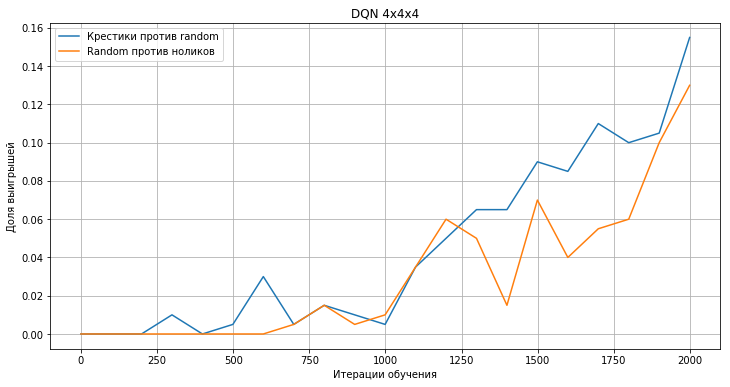

In [69]:
plt.figure(figsize=(12, 6))
plt.title('DQN 4x4x4')
plt.xlabel('Итерации обучения')
plt.ylabel('Доля выигрышей')
plt.grid(True)
plt.plot([0] + iters, [0] + hist_p1, label='Крестики против random')
plt.plot([0] + iters, [0] + hist_p2, label='Random против ноликов')
plt.legend();

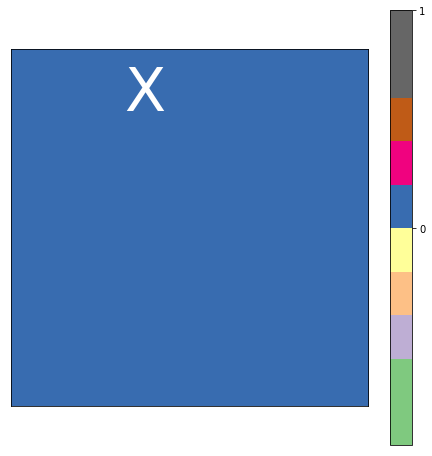

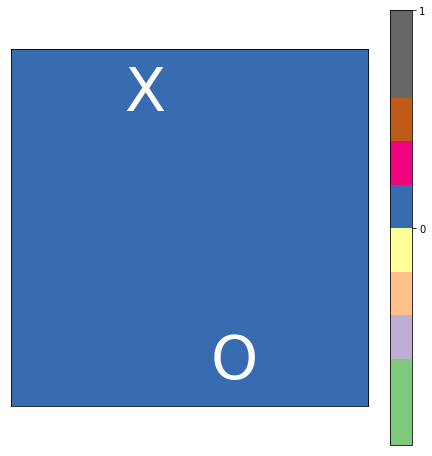

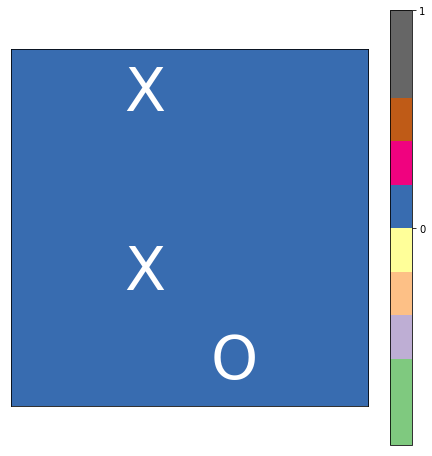

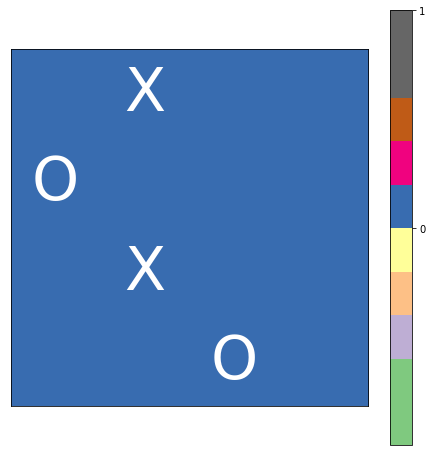

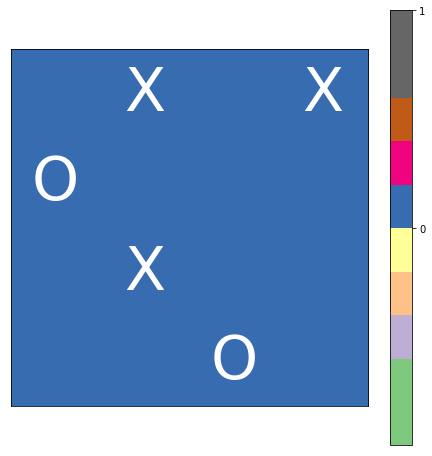

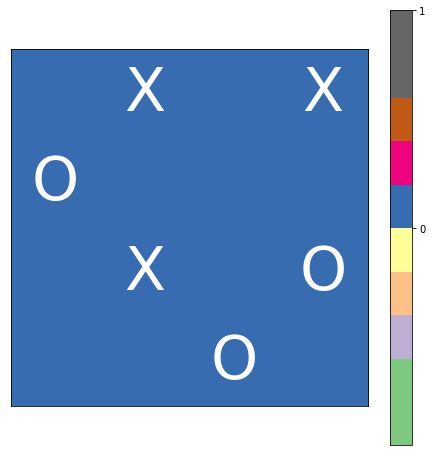

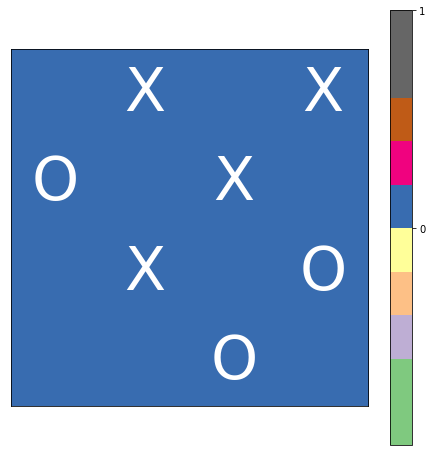

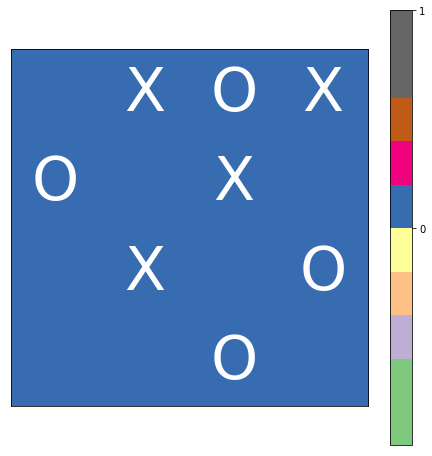

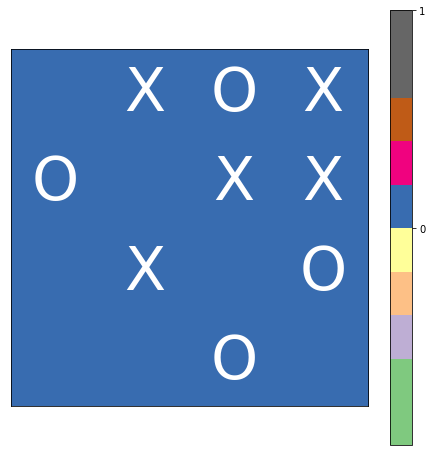

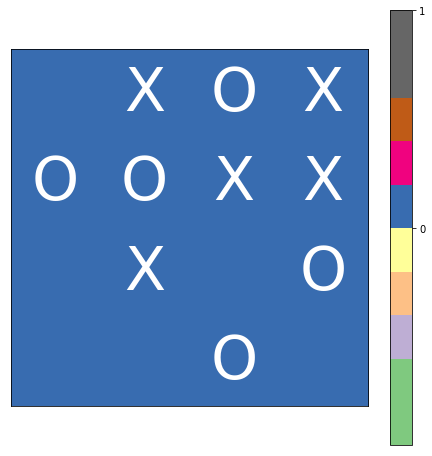

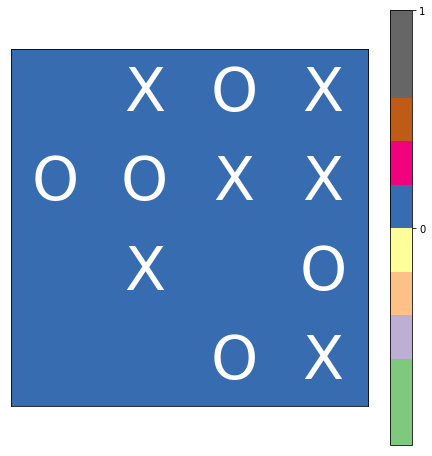

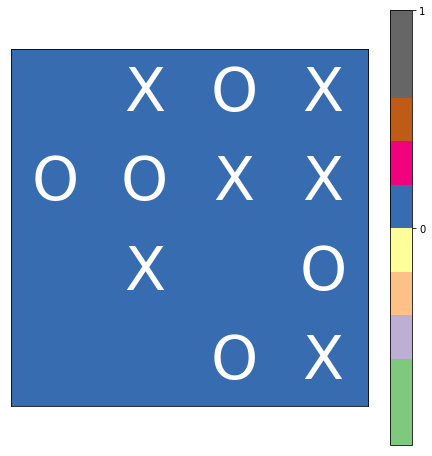

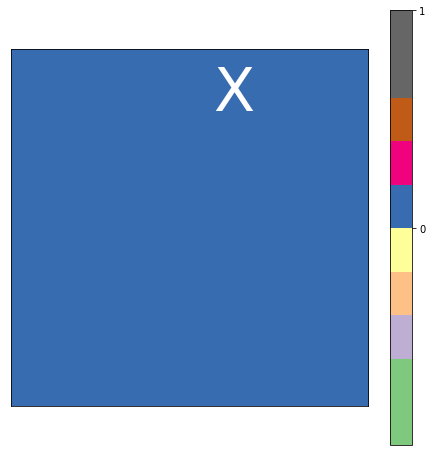

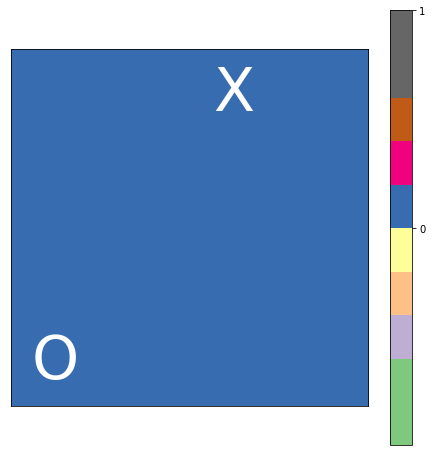

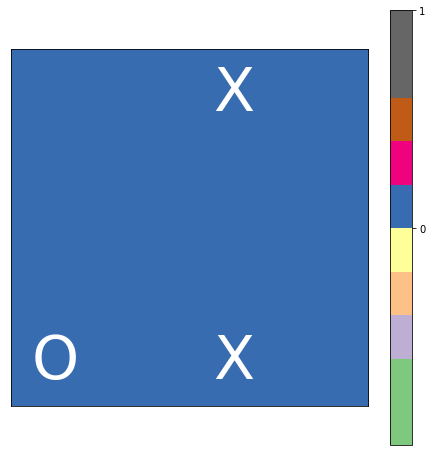

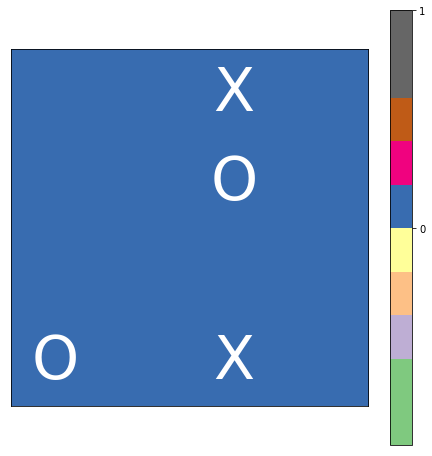

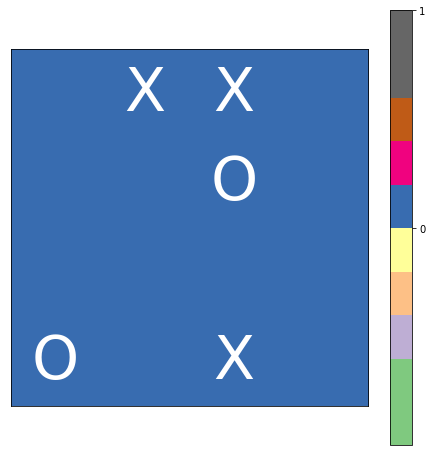

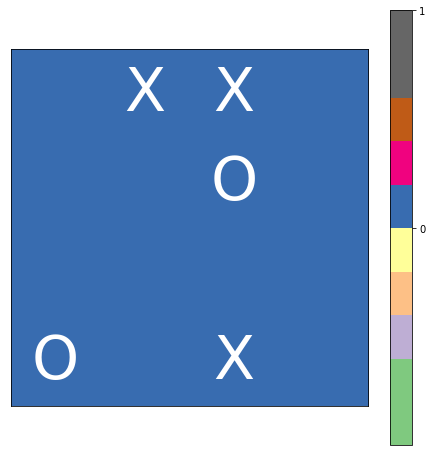

(0, 0)

In [73]:
play_game_model(env, model1, print_board=True, player1_random=False, player2_random=False)
play_game_model(env, model2, print_board=True, player1_random=False, player2_random=False)